# **(Feature Engineeing Notebook)**


Part of CRISP-DM Data Preparation


## Objective

* Engineering features for Regression models

## Inputs
* inputs/datasets/cleaned/TrainSetCleaned.csv* 
inputs/datasets/cleaned/TestSetCleaned.csv

## Outputs* Generate a list with variables to engineerp

---

## Change working directory

* Notebooks are stored in a subfolder, therefore when running the notebook in the editor, we need to change the working directory from the current folder to the parent folder.

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/house_sales_predictor/jupyter_notebooks'

## We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


## Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/house_sales_predictor'

## Load cleaned data Test and Train sets

* Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)


1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1828       0.0           3.0           Av          48          Unf   
1       894       0.0           2.0           No           0          Unf   
2       964       0.0           2.0           No         713          ALQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0       1774         774          Unf       2007.0  ...    11694        90.0   
1        894         308          Unf       1962.0  ...     6600        60.0   
2        163         432          Unf       1921.0  ...    13360        80.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0       452.0          108            5            9         1822       2007   
1         0.0            0            5            5          894       1962   
2         0.0            0            7            5          876       1921   

   YearRemodAdd  SalePrice  
0          2007     314813  
1          1962     109500  
2          2006     163500  

[3 rows x 22 columns]

* Test sets

In [5]:
test_set_path = "outputs/datasets/cleaned/TestSetCleaned.csv"
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      2515       0.0           4.0           No        1219          Rec   
1       958     620.0           3.0           No         403          BLQ   
2       979     224.0           3.0           No         185          LwQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0        816         484          Unf       1975.0  ...    32668        69.0   
1        238         240          Unf       1941.0  ...     9490        79.0   
2        524         352          Unf       1950.0  ...     7015        69.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         0.0            0            3            6         2035       1957   
1         0.0            0            7            6          806       1941   
2       161.0            0            4            5          709       1950   

   YearRemodAdd  SalePrice  
0          1975     200624  
1          1950     133000  
2          1950     110000  

[3 rows x 22 columns]

## Revisit Data Exploration

In feature engineering, we are interested to evaluate which potential transformations could be used to engineer the features further.

In [6]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation and PPS Analysis of Cleaned Train Set Data


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate Correlations and Predictive Power Score

In [8]:
ts_corr_pearson, ts_corr_spearman, pps_matrix = CalculateCorrAndPPS(TrainSet)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  462.0  0.059  0.105  0.0  0.0  0.0  0.075  0.618


* Display in heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



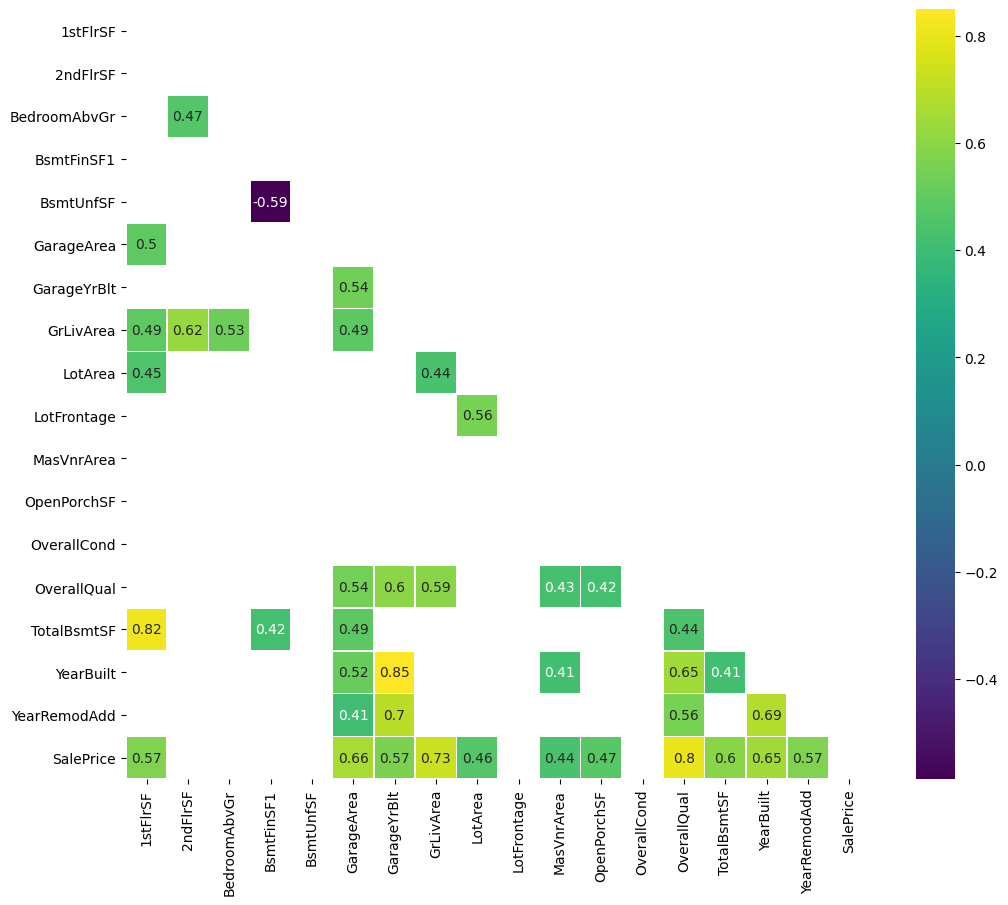



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



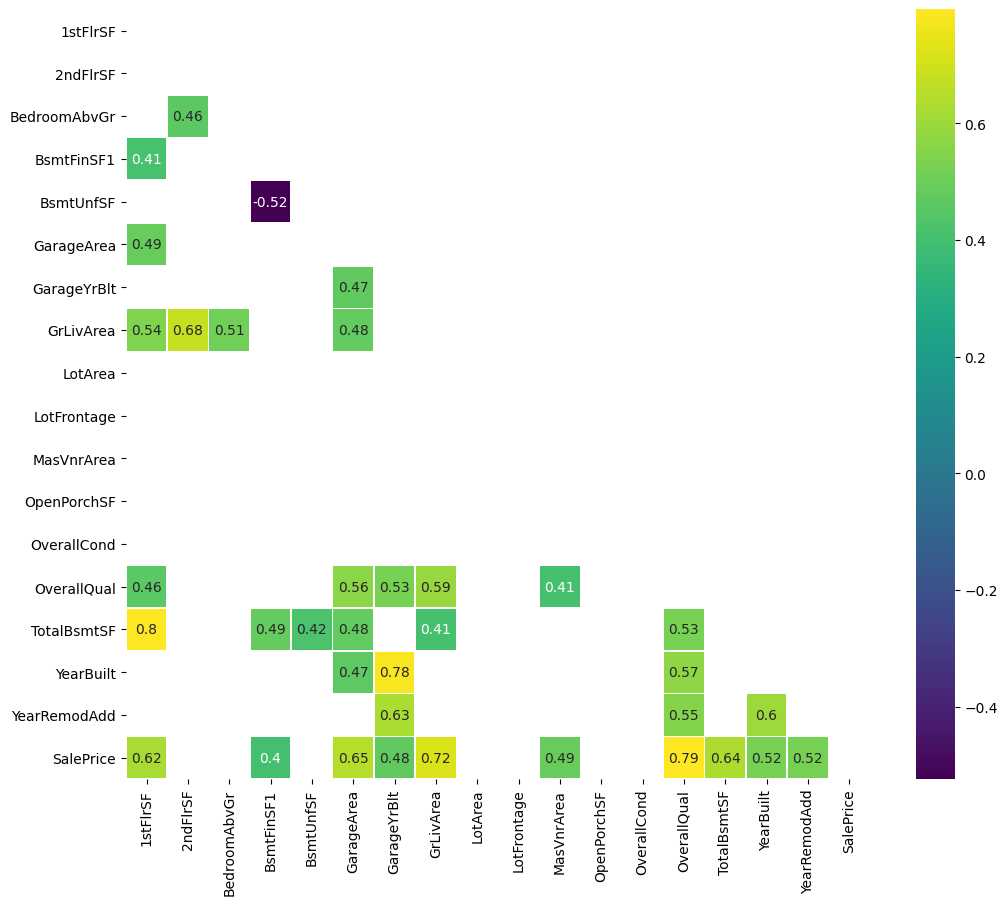



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



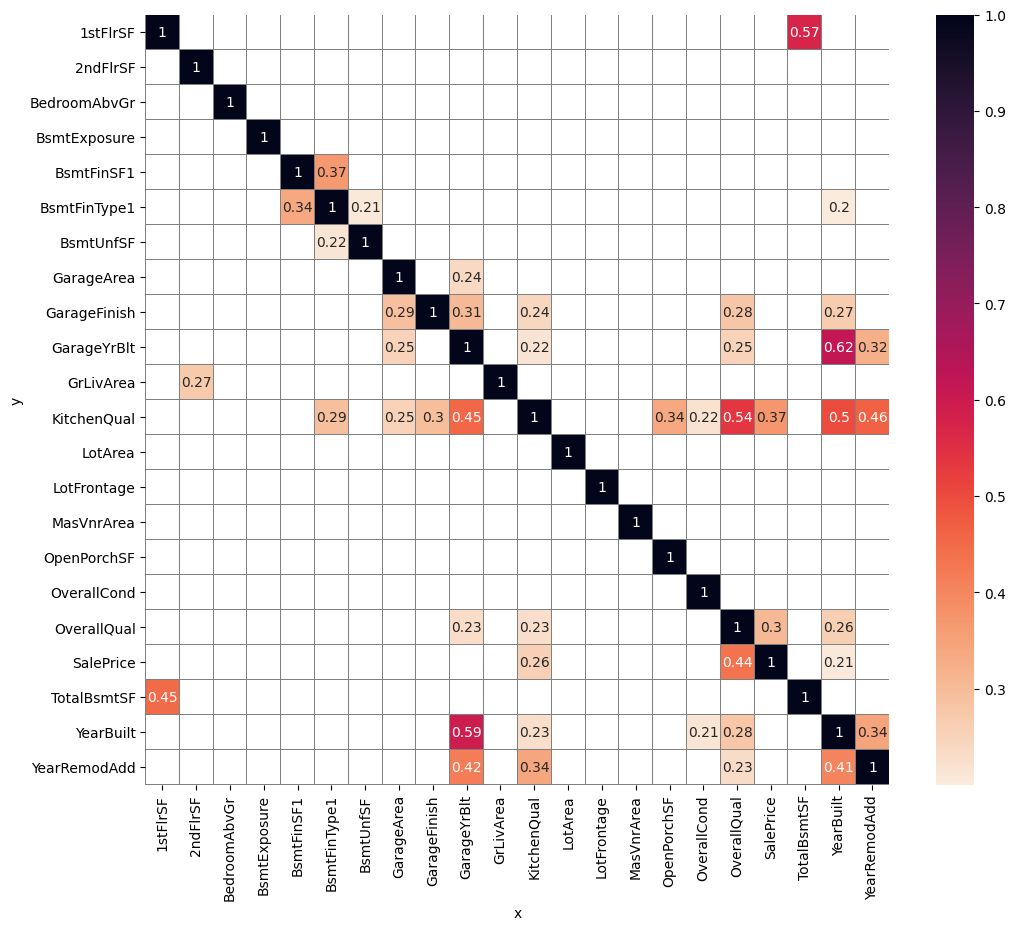

In [9]:
DisplayCorrAndPPS(df_corr_pearson = ts_corr_pearson,
                  df_corr_spearman = ts_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

## Feature Engineering

* We will use the custom function from the feature engineering lesson from CI to help us assess the feasibility and usefulness of various engineering techniques.

In [10]:

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


# def DiagnosticPlots_Numerical(df, variable):
#     fig, axes = plt.subplots(1, 3, figsize=(12, 4))
#     sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
#     stats.probplot(df[variable], dist="norm", plot=axes[1])
#     sns.boxplot(x=df[variable], ax=axes[2])

#     axes[0].set_title('Histogram')
#     axes[1].set_title('QQ Plot')
#     axes[2].set_title('Boxplot')
#     fig.suptitle(f"{variable}", fontsize=30, y=1.05)
#     plt.tight_layout()
#     plt.show()


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, ax=axes[0])  # Removed the element parameter
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

* we will test three possible types of feature engineering methods:
* Categorical Encoding* 
Numerical Transformation* Handlingng of outliers using the Windsorize* r
Smart Correlation Selection

At each step, we will apply the feature engineering method and assess it's effects. If we decide that it helps to make the data more suitable for maching learning we keep track of the step in a table at the end of this notebook in order to build it into our feature engine pipeline in the next step of the ML model development.

The target variable 'SalePrice' is left out of all feature engineering, since it is not a feature

## Categorical Encoding

Ordinal Encoding: replaces categories with ordinal numbers

* Step 1: Select the categorical variables, which are currently encoded using strings in the data set.

In [11]:
variables_engineering= ['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual']
variables_engineering

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

Step 2: Create a separate DataFrame with the variables to be engineered.

In [12]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtExposure  3 non-null      object
 1   BsmtFinType1  3 non-null      object
 2   GarageFinish  3 non-null      object
 3   KitchenQual   3 non-null      object
dtypes: object(4)
memory usage: 224.0+ bytes


Step 3: Create engineered variables by applying the transformation, assess the engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



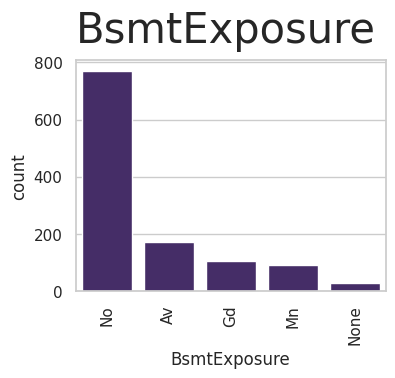

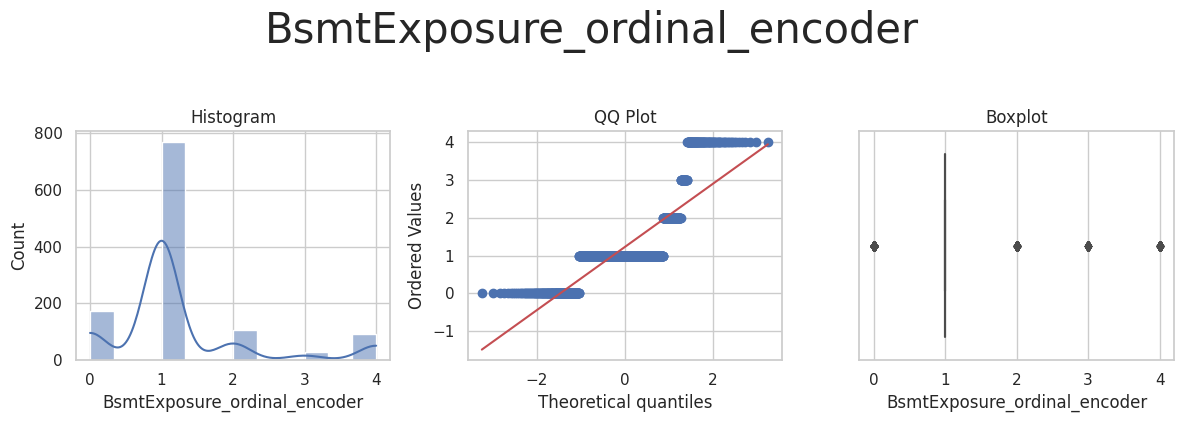



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



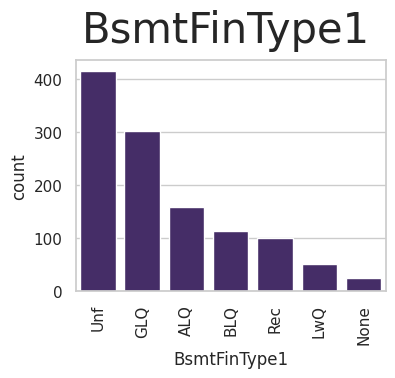

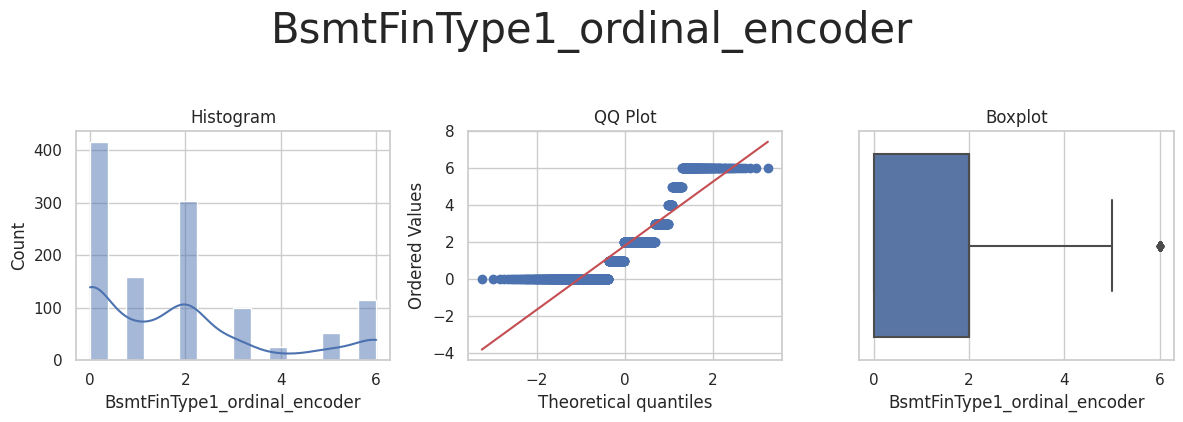



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



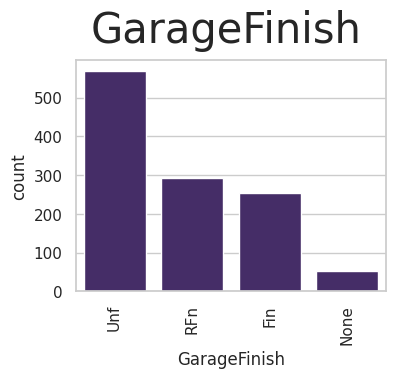

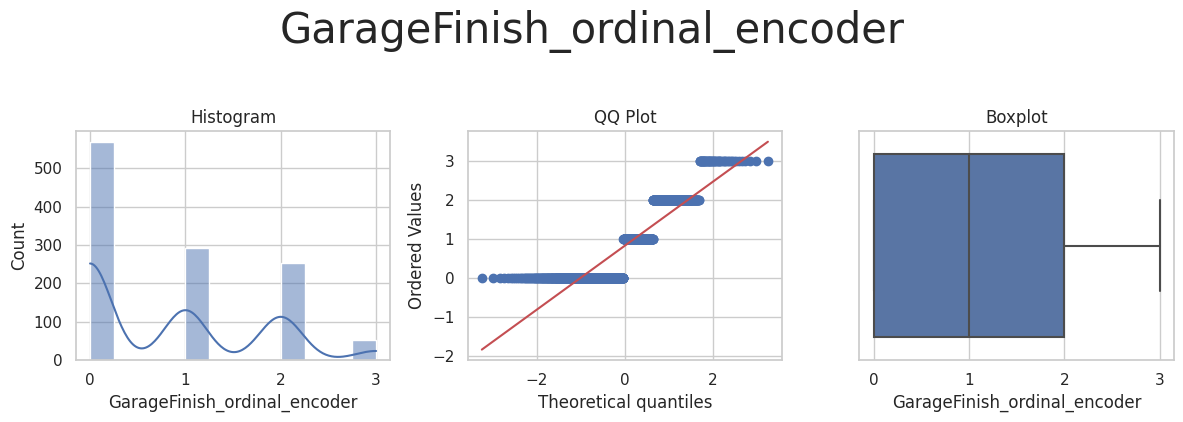



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



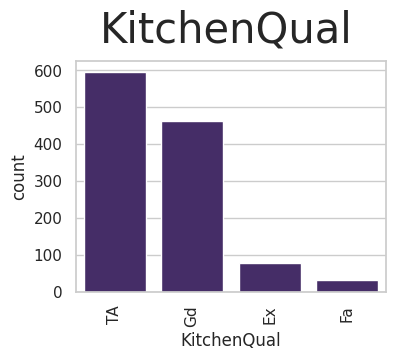

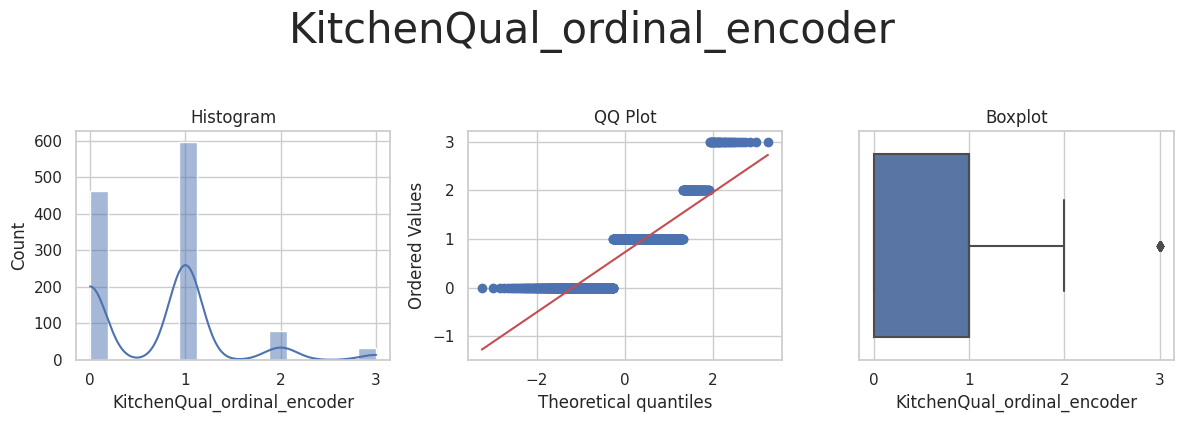

In [13]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

The encoding has been successful.

Step 4: Apply the transformation to the Train and Test sets. We will apply the OrdinalEncoder to all categorical variables in the final Feature Engineering pipeline.

## Numerical Transformation

The custom function above will test several numerical transformations: "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson". The goal is to improve the distribution of the data to fit more closely a normal distribution. Machine Learning models tend to be more effective when the features passed to them are normally distributed.

Step 1: Select the variable to be transformed. Because the data set contains a lot of numerical data, we start with only those data that are measured in feet or square feet.

In [14]:
variables_engineering= ['1stFlrSF','2ndFlrSF','GrLivArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF',
                        'GarageArea','LotArea','LotFrontage','OpenPorchSF','MasVnrArea']
variables_engineering

['1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'GarageArea',
 'LotArea',
 'LotFrontage',
 'OpenPorchSF',
 'MasVnrArea']

Step 2: Create a separate DataFrame with the selected variables.

In [15]:
df_engineering = TestSet[variables_engineering].copy()
df_engineering.head(3)

1stFlrSF  2ndFlrSF  GrLivArea  BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  \
0      2515       0.0       2515        1219        816         2035   
1       958     620.0       1578         403        238          806   
2       979     224.0       1203         185        524          709   

   GarageArea  LotArea  LotFrontage  OpenPorchSF  MasVnrArea  
0         484    32668         69.0            0         0.0  
1         240     9490         79.0            0         0.0  
2         352     7015         69.0            0       161.0

Step 3: Apply the transformation to the selected variables using the custom function above and use the output to assess which transformations are most suitable for which variables. We keep track of the most appropriate transformations in the table at the end of this notebook.

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



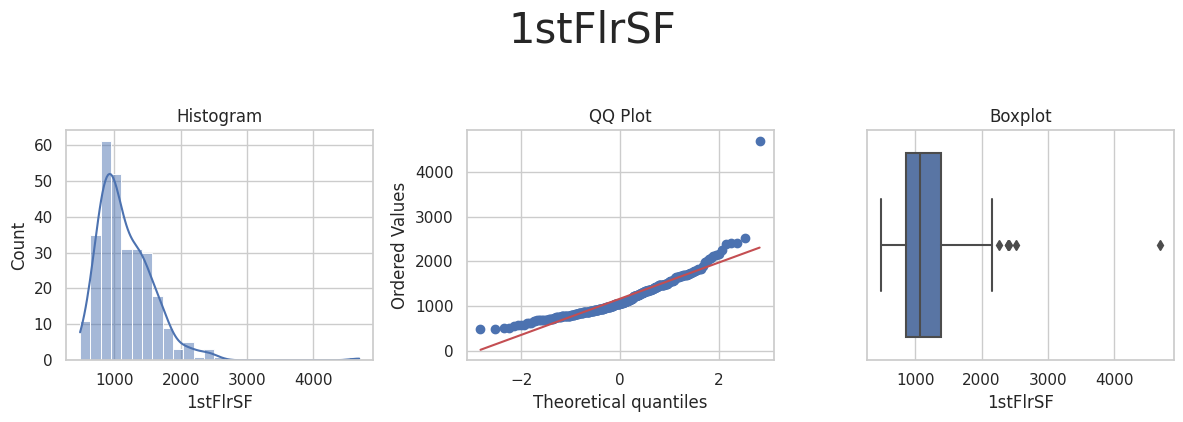

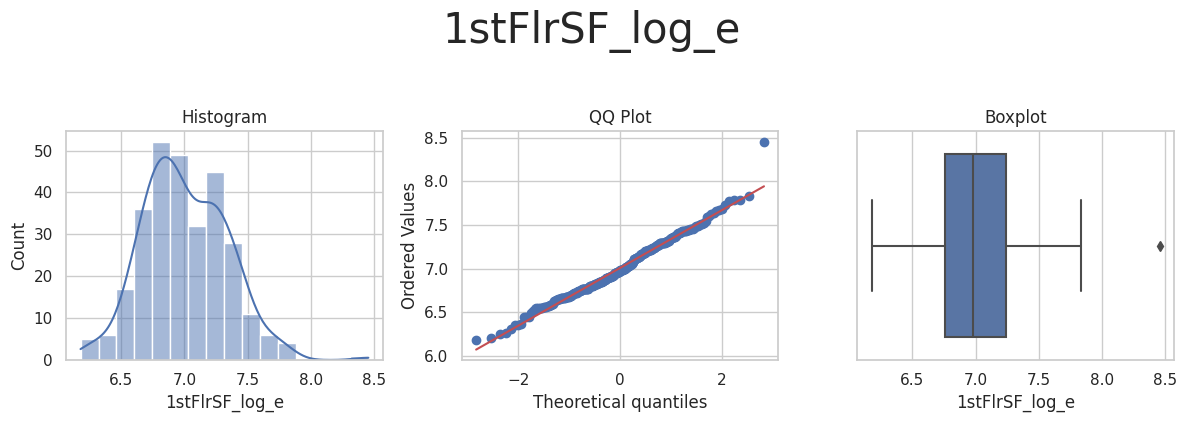

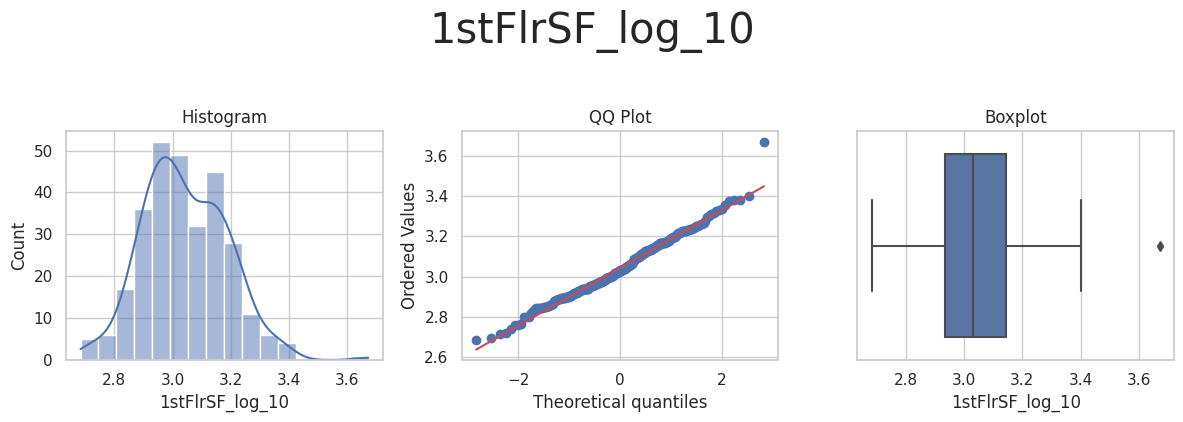

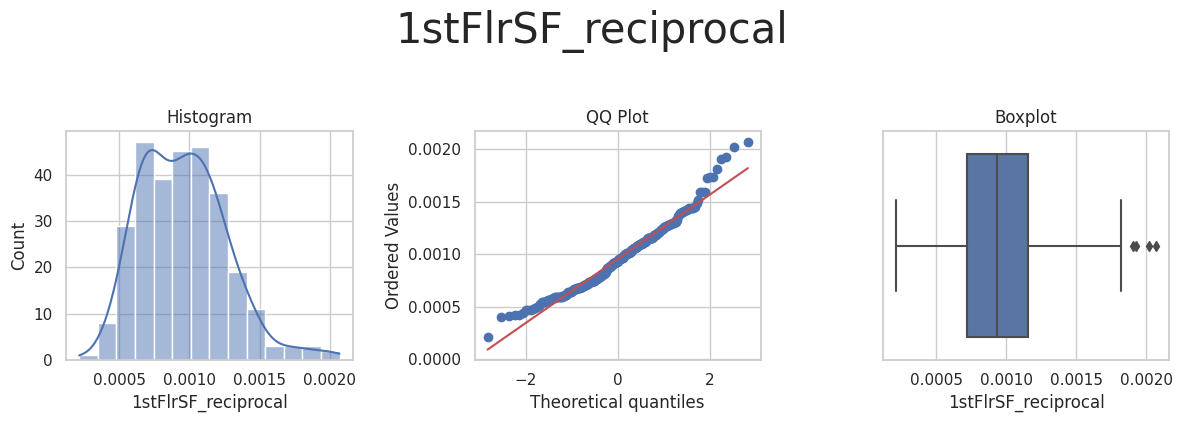

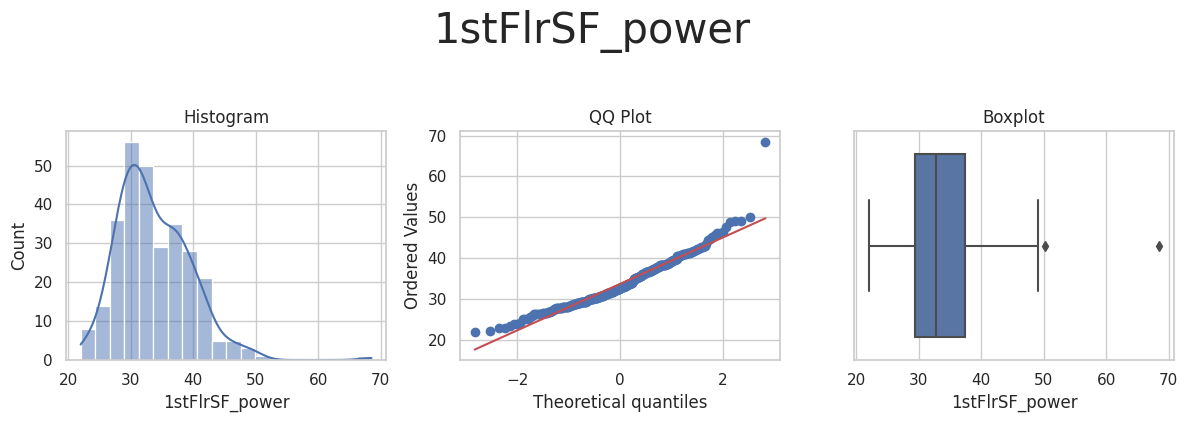

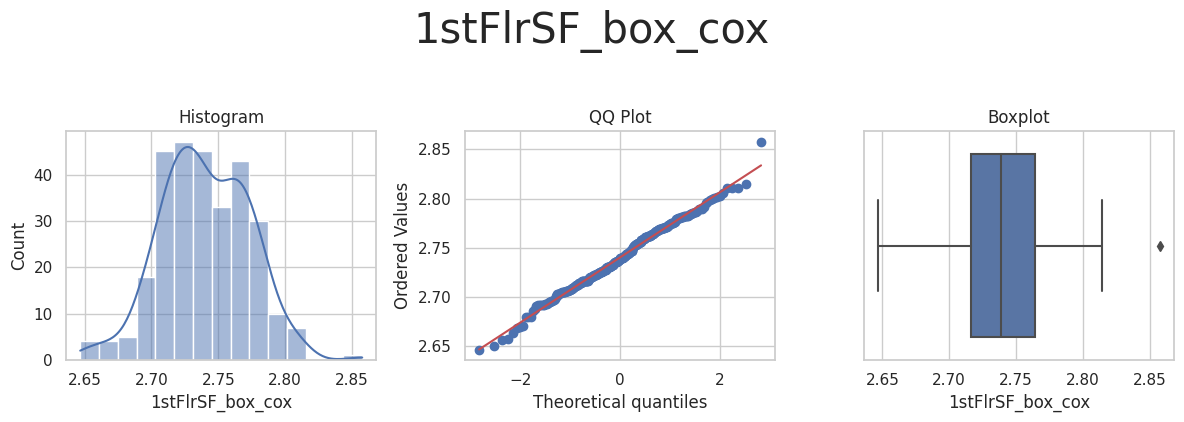

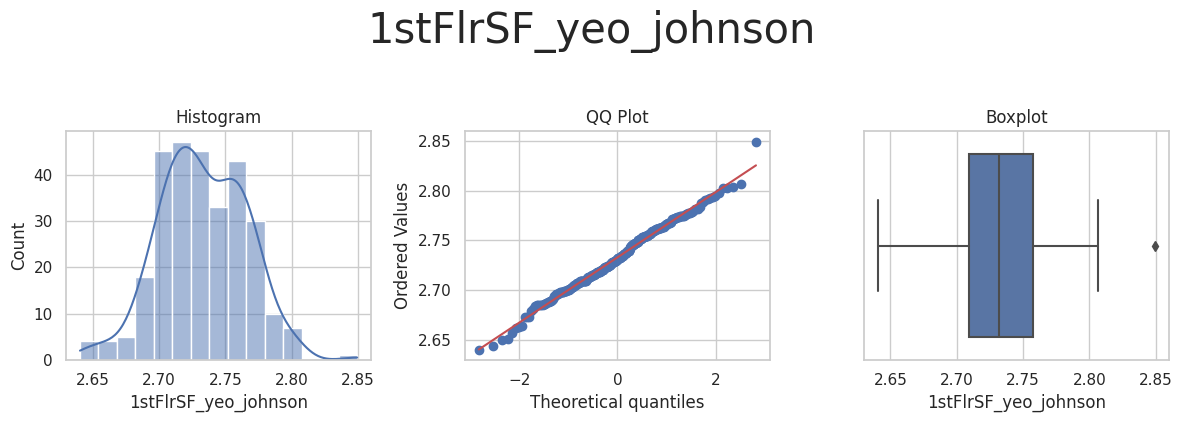



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



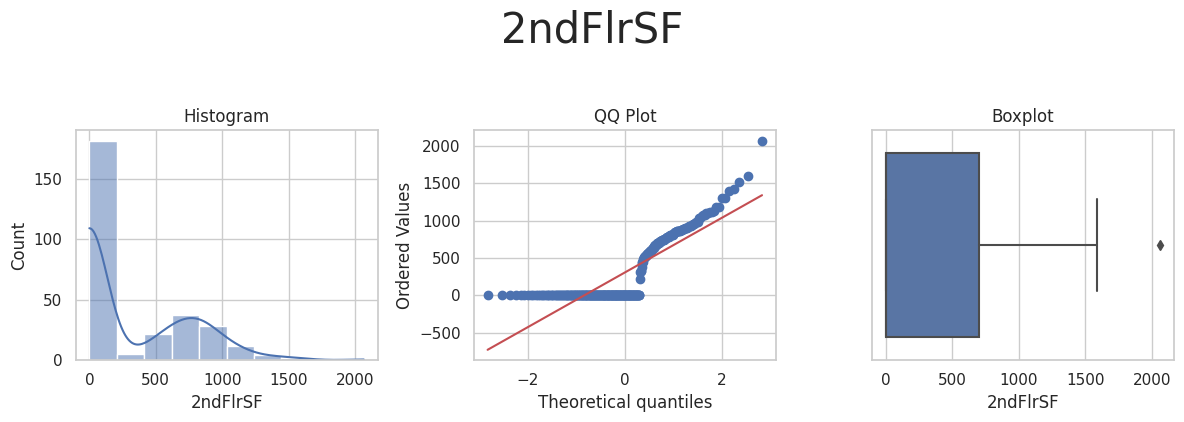

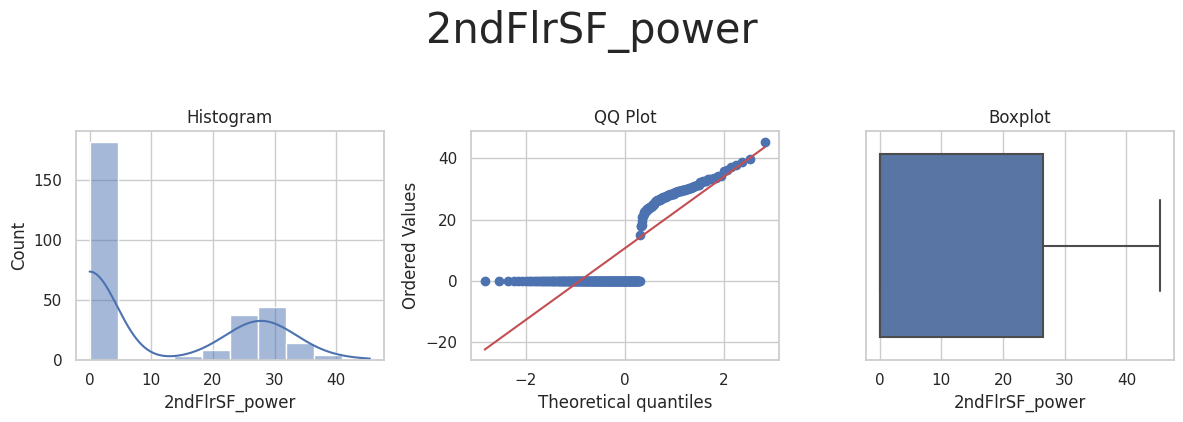

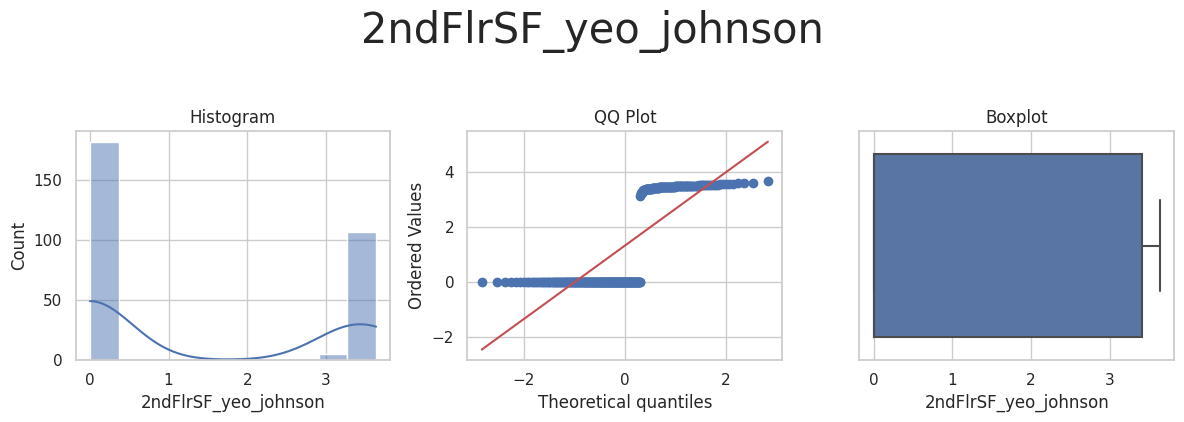



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



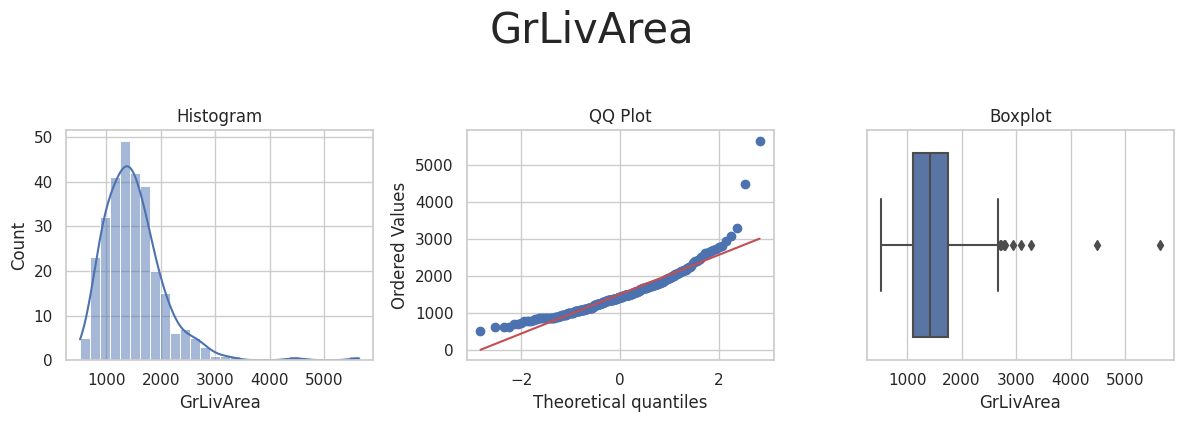

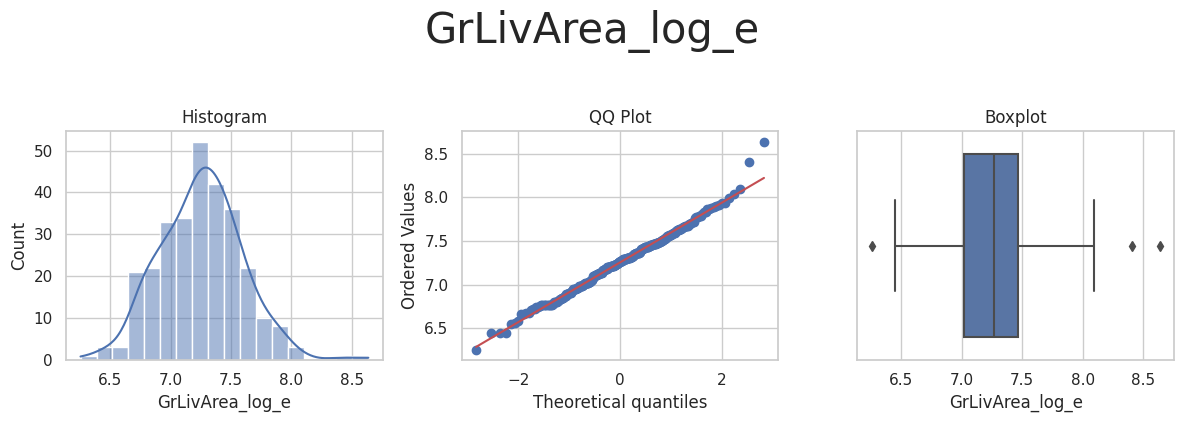

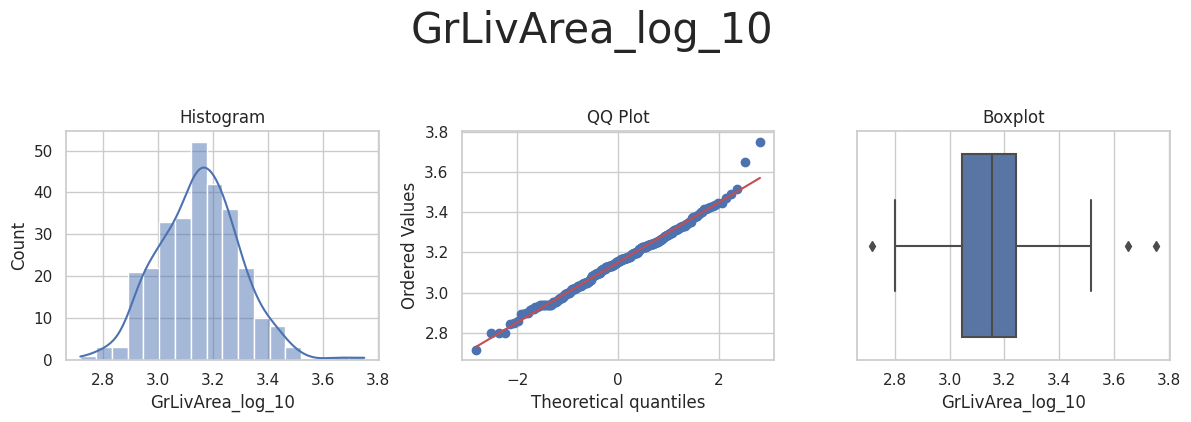

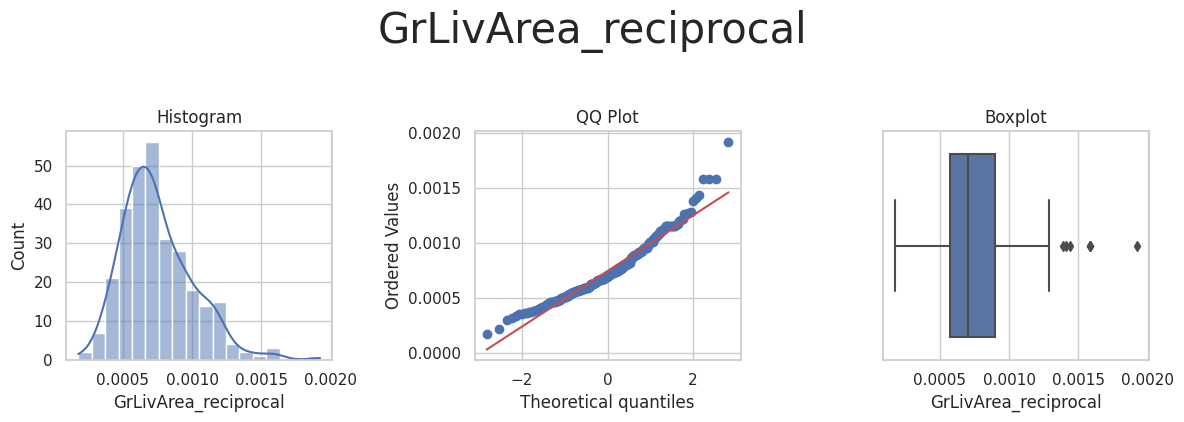

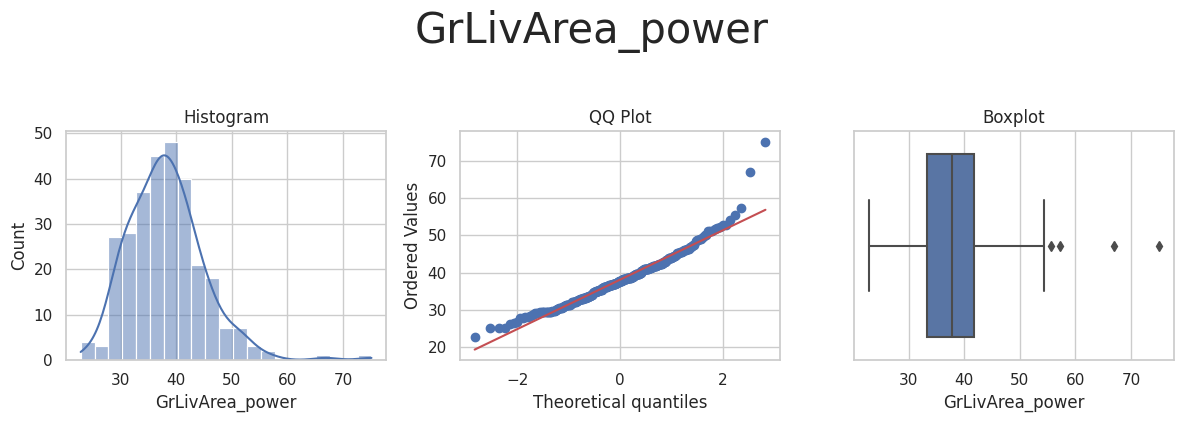

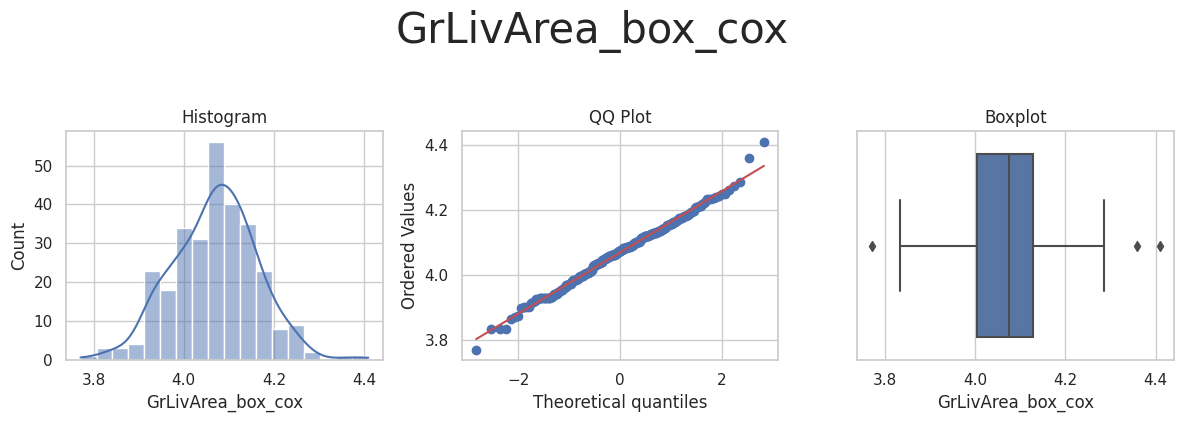

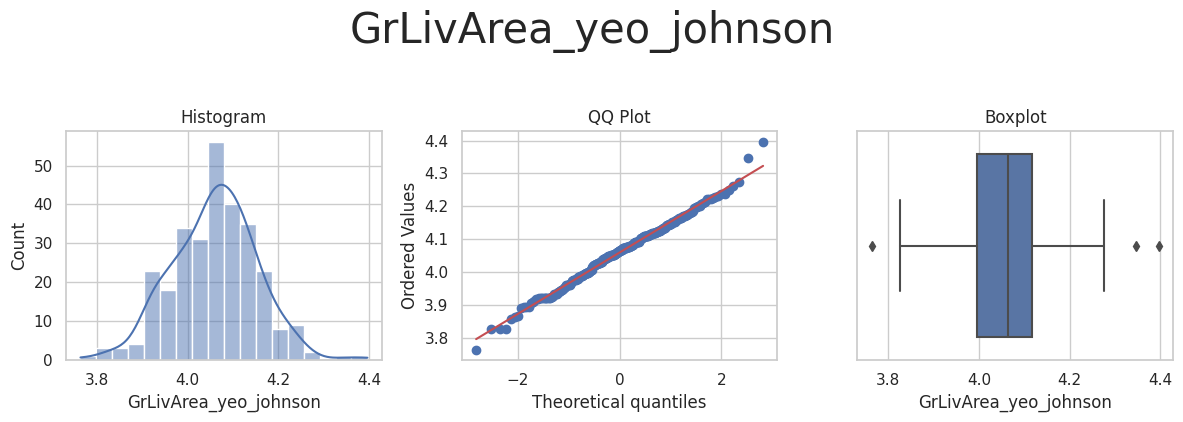



* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



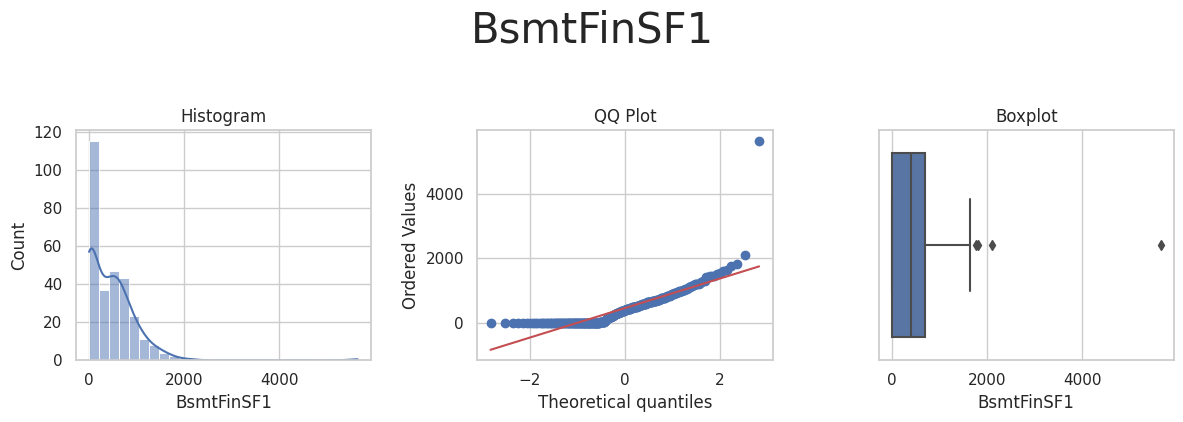

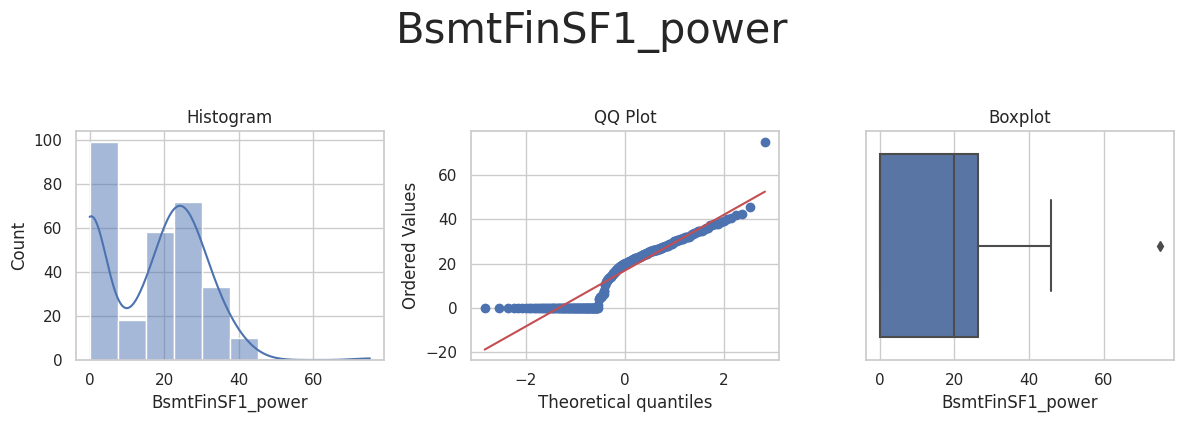

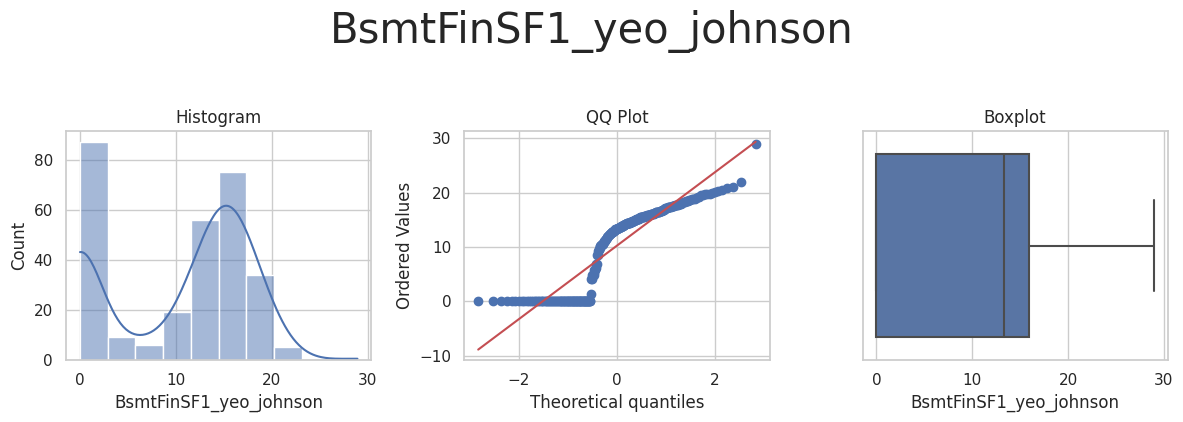



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 



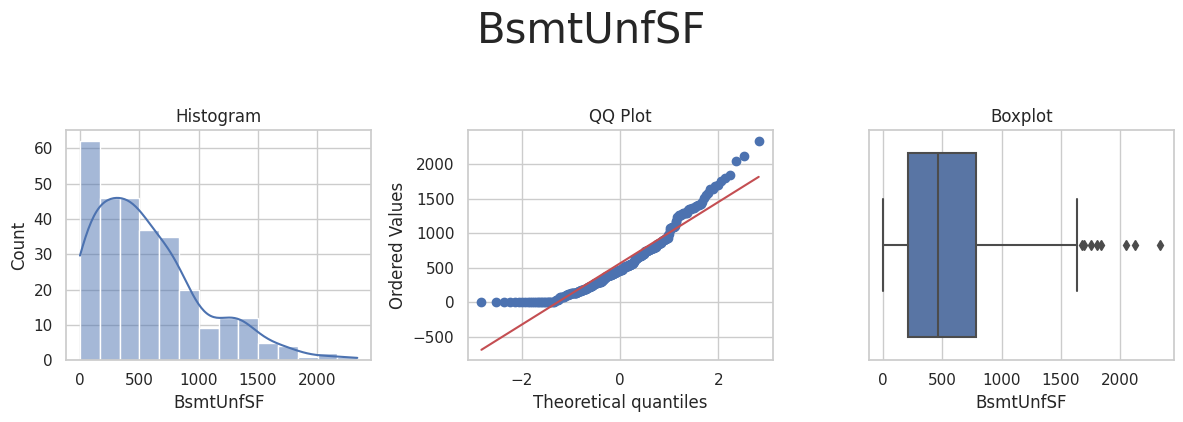

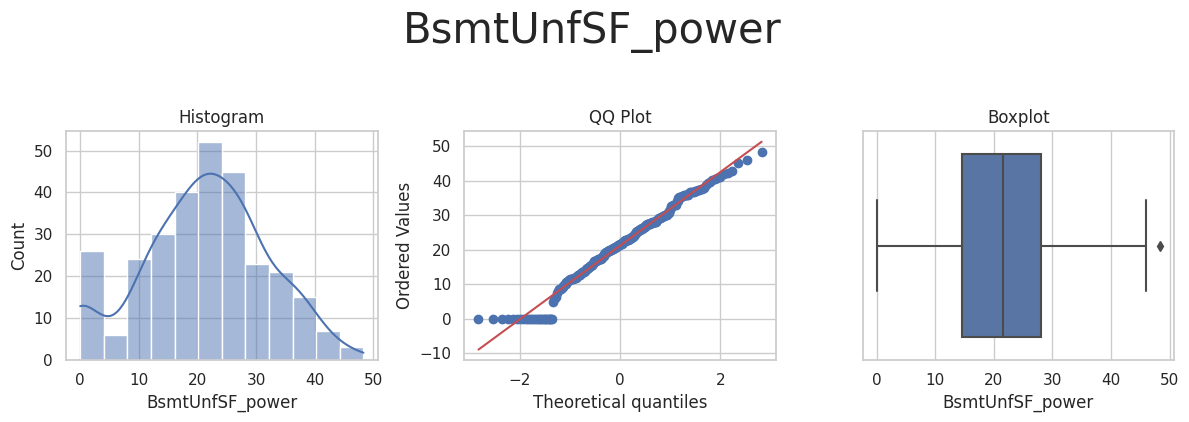

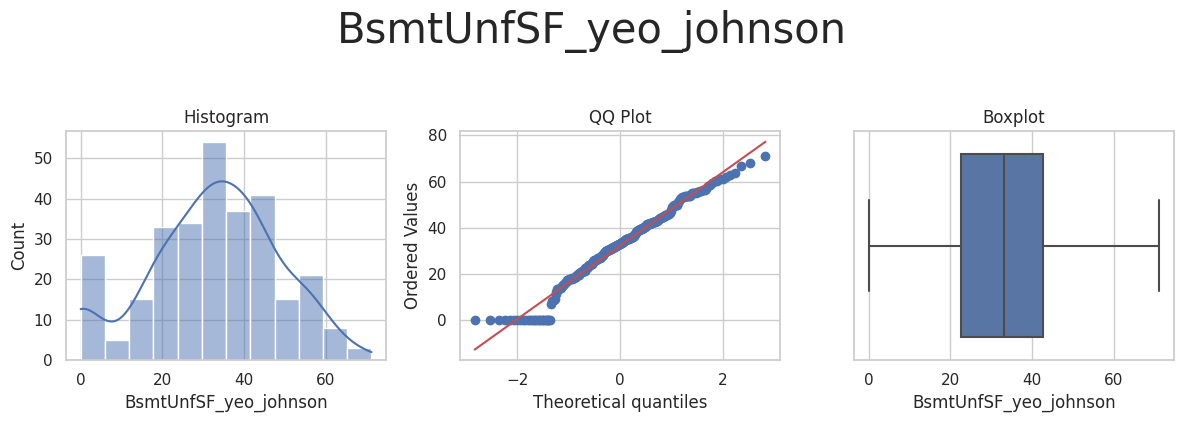



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



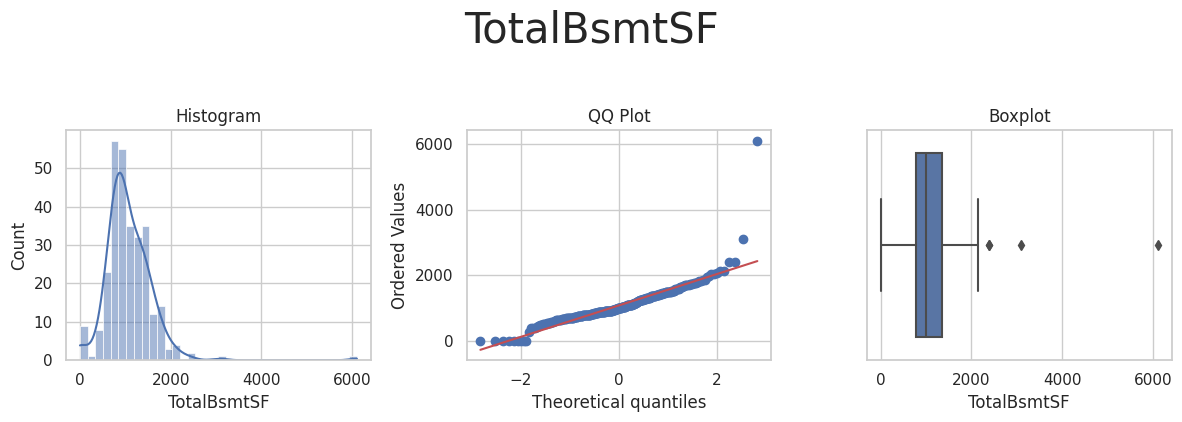

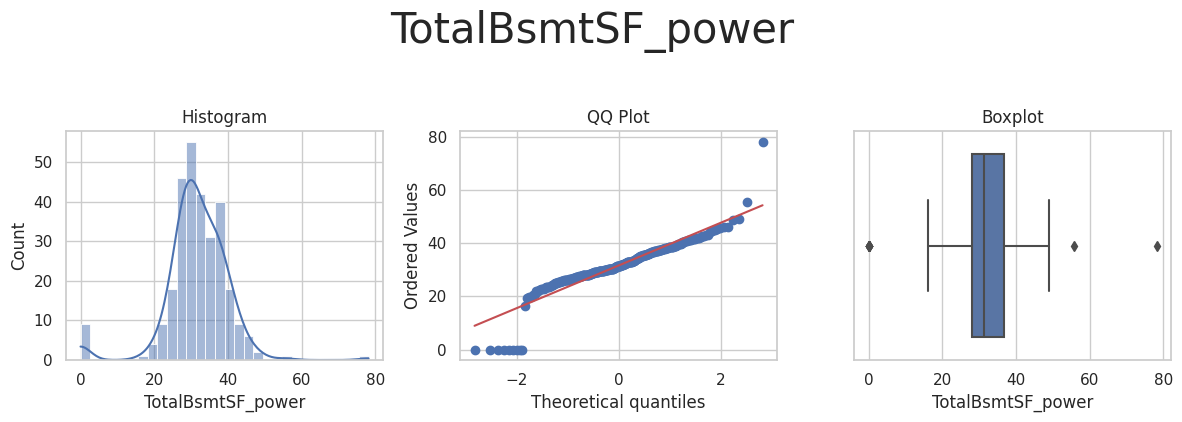

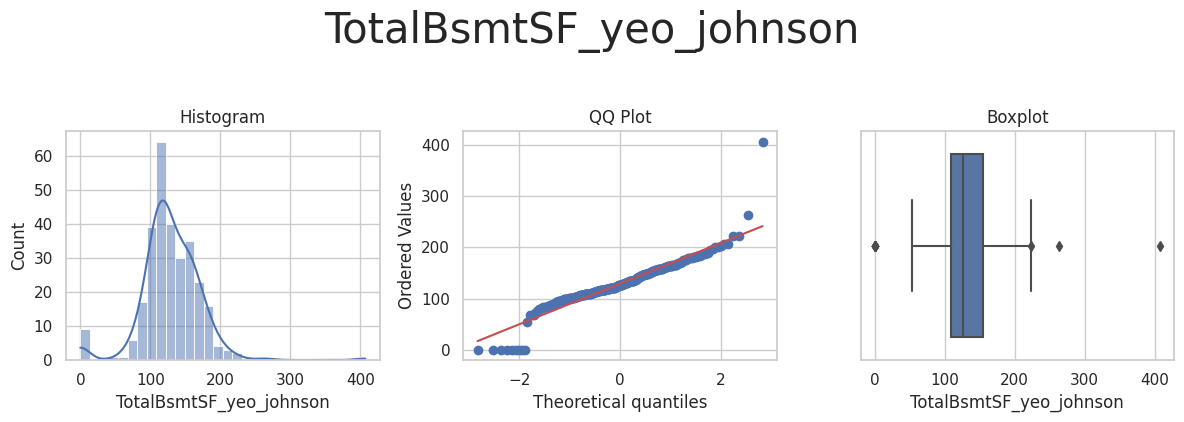



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



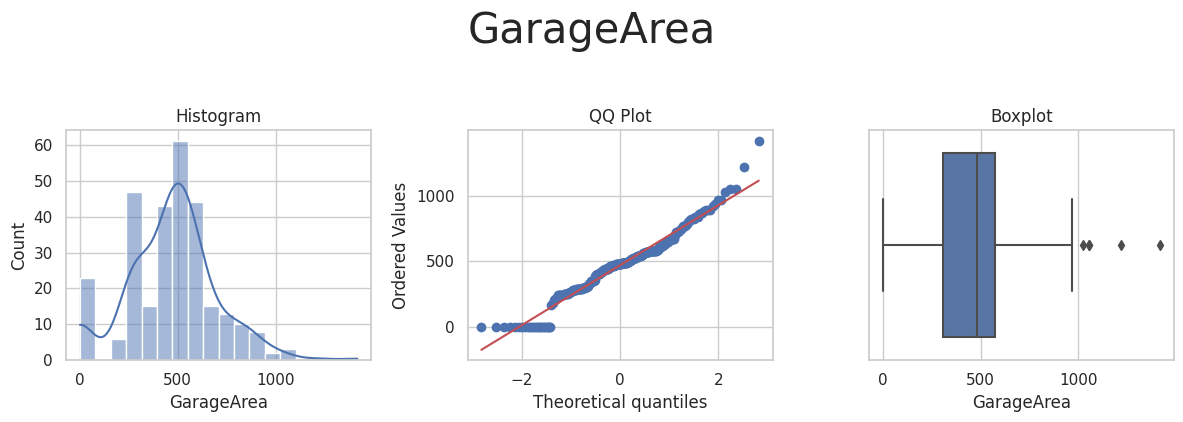

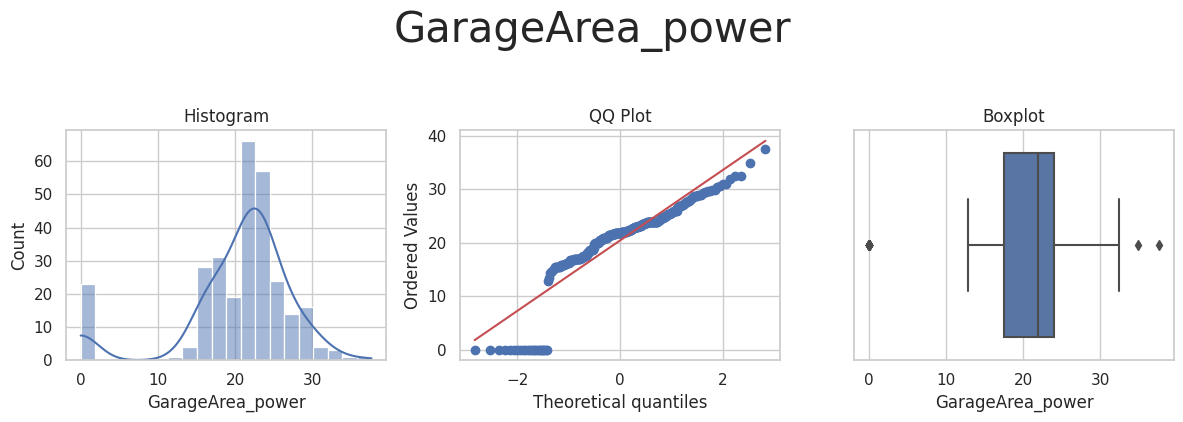

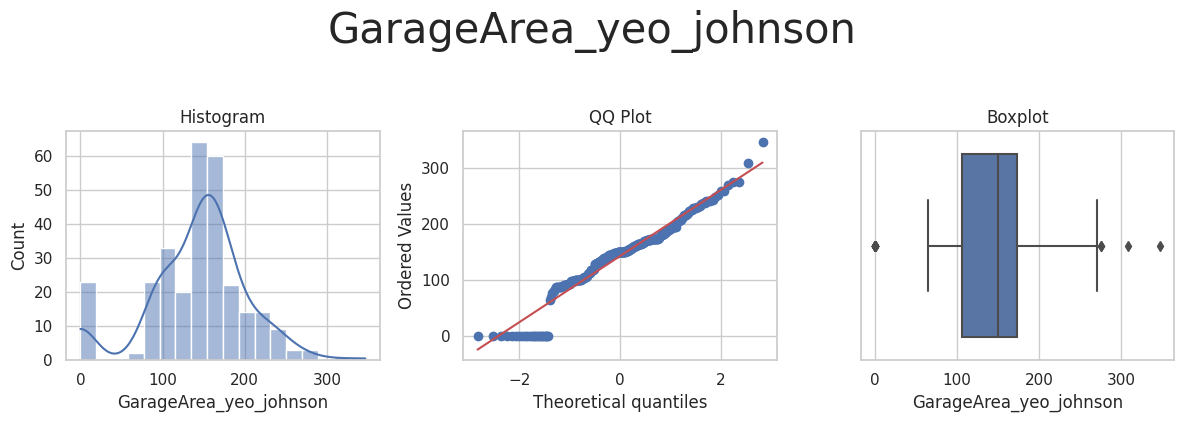



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



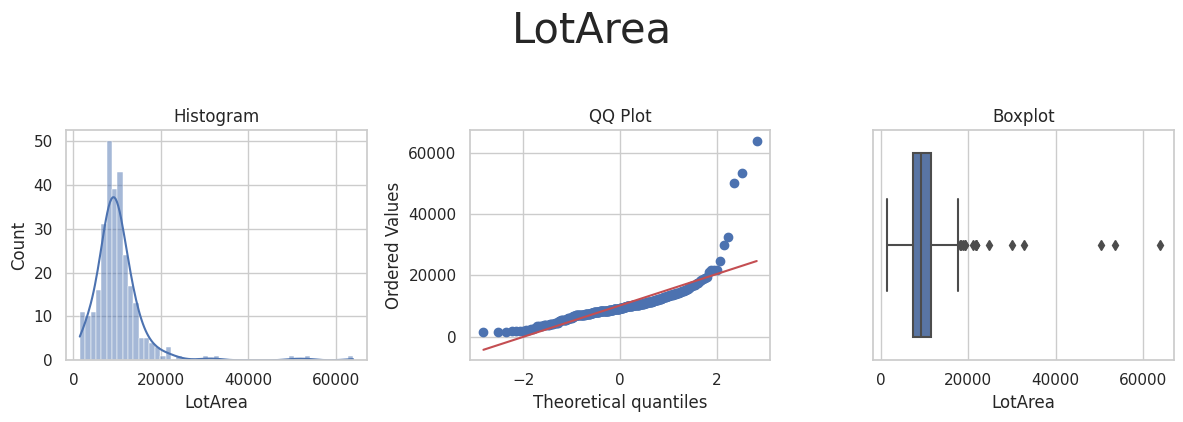

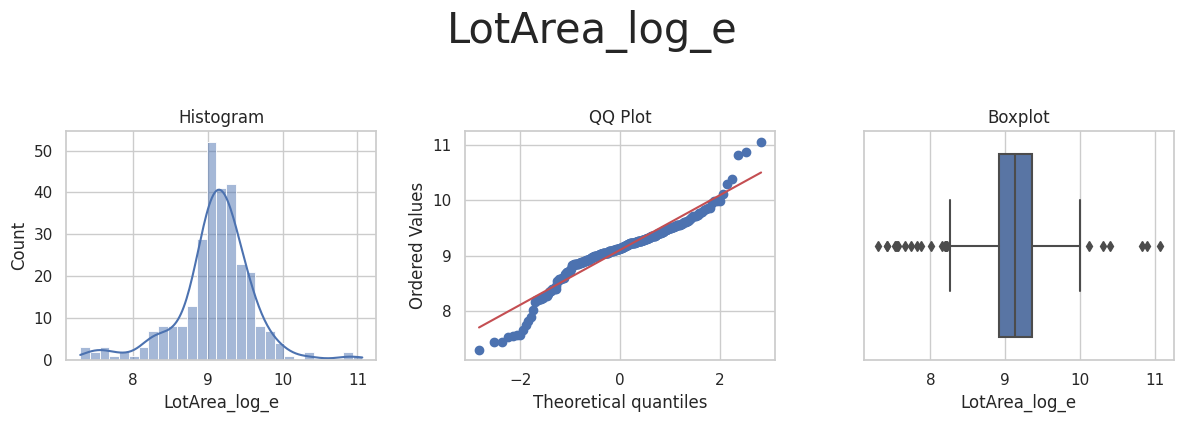

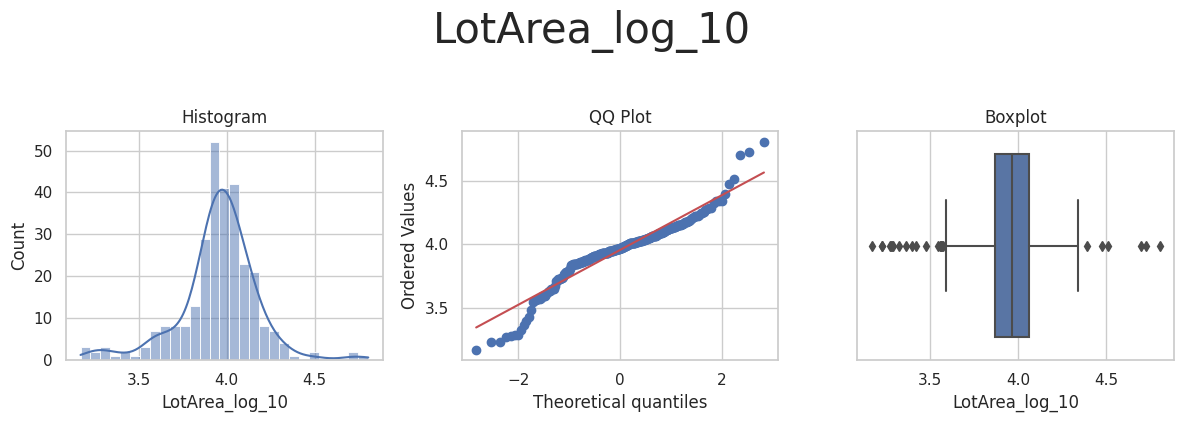

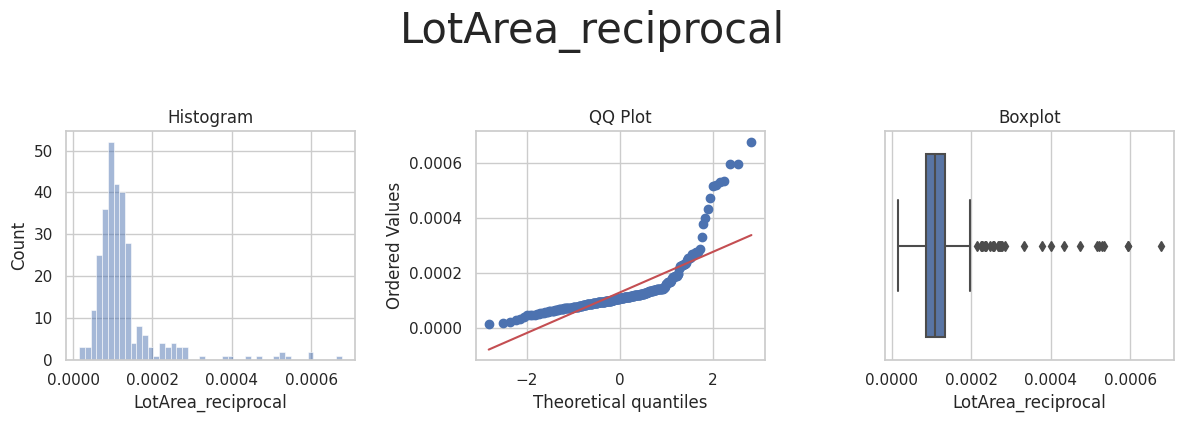

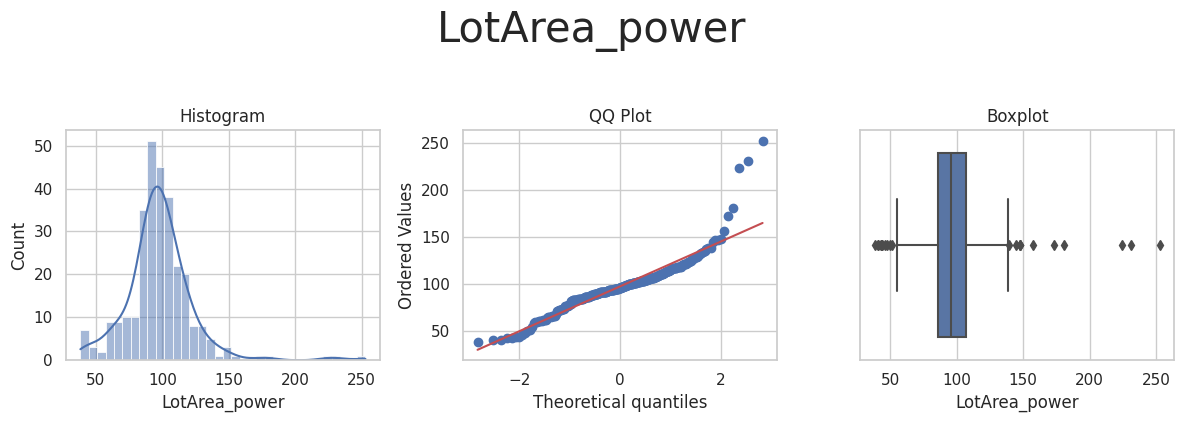

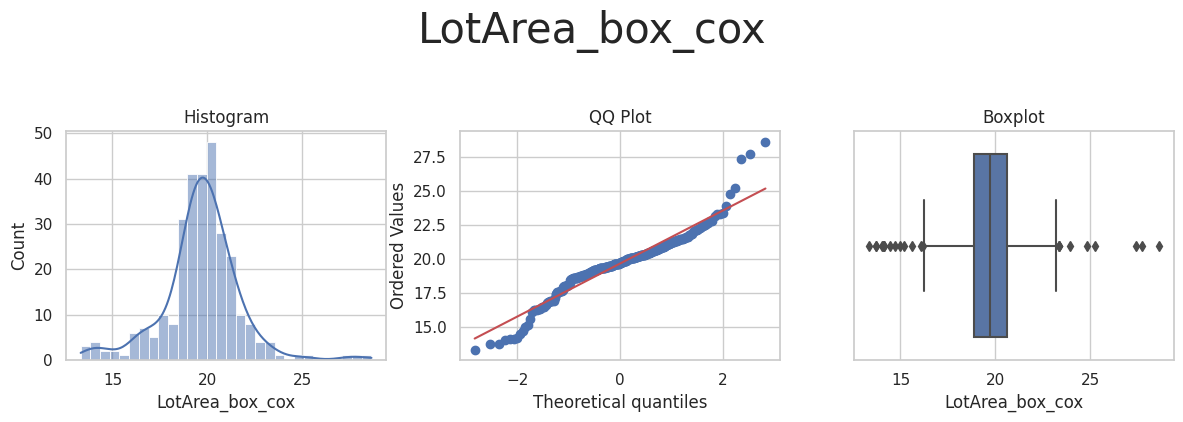

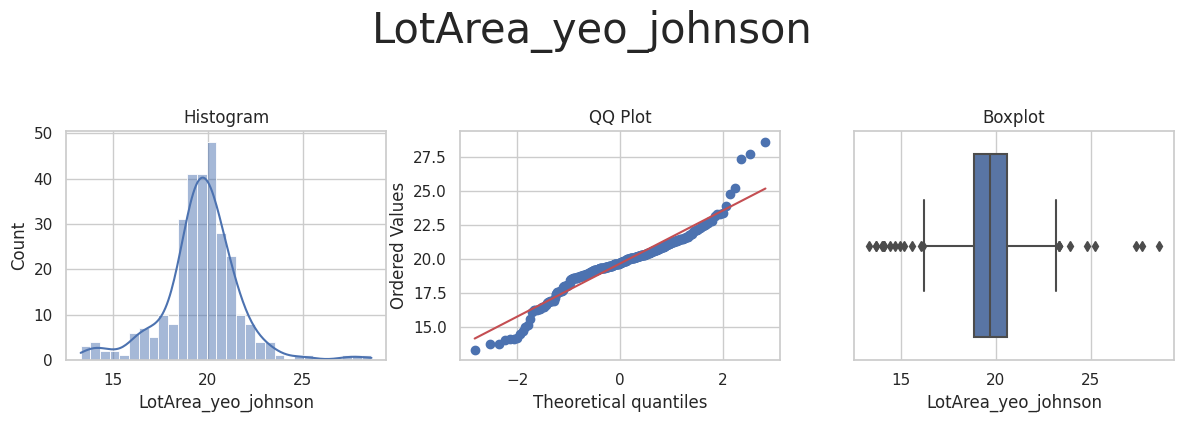



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



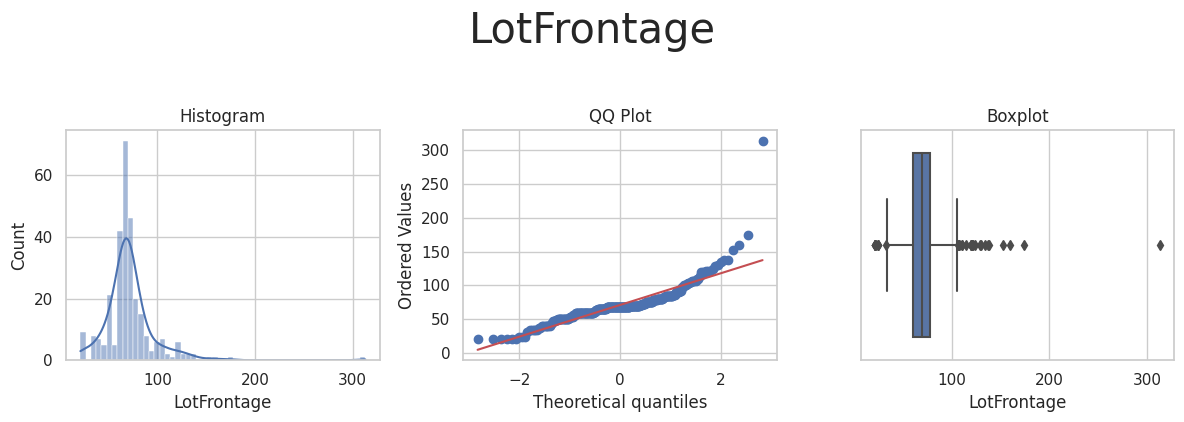

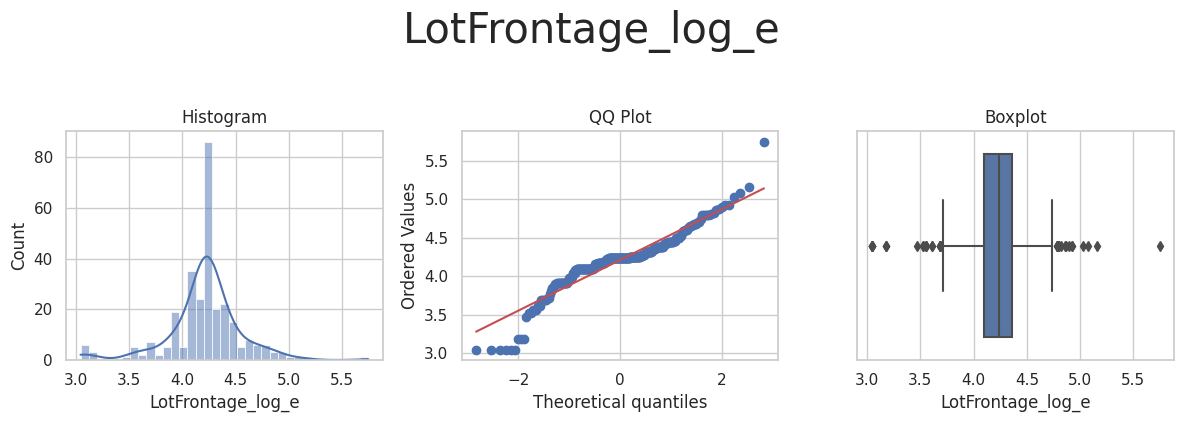

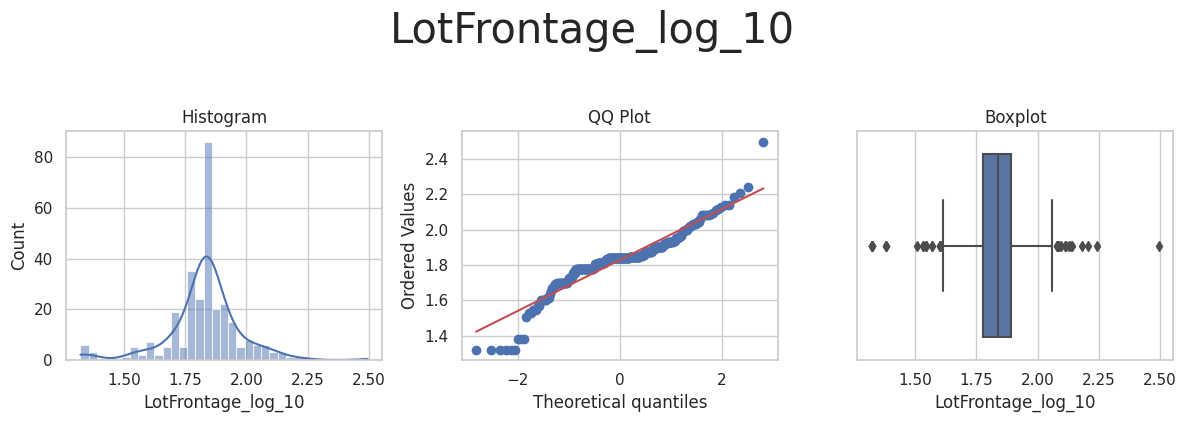

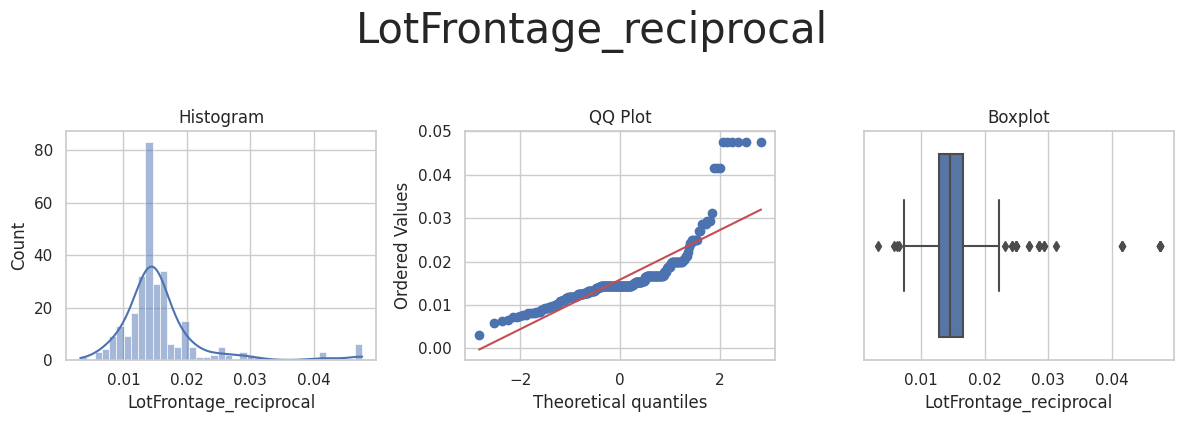

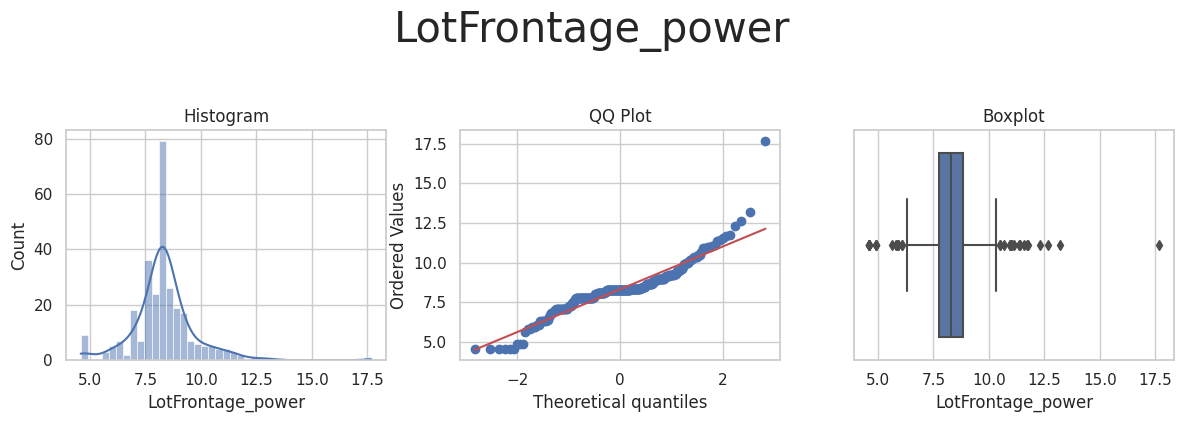

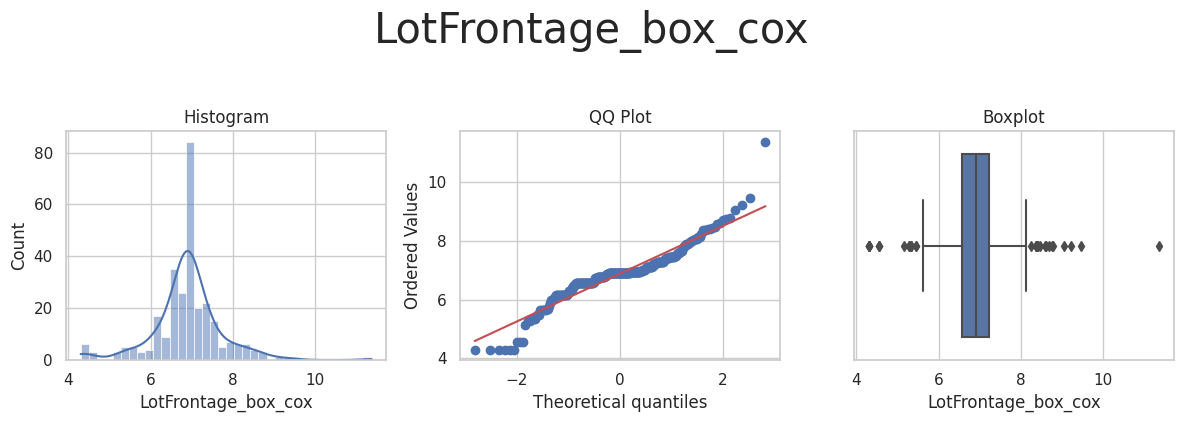

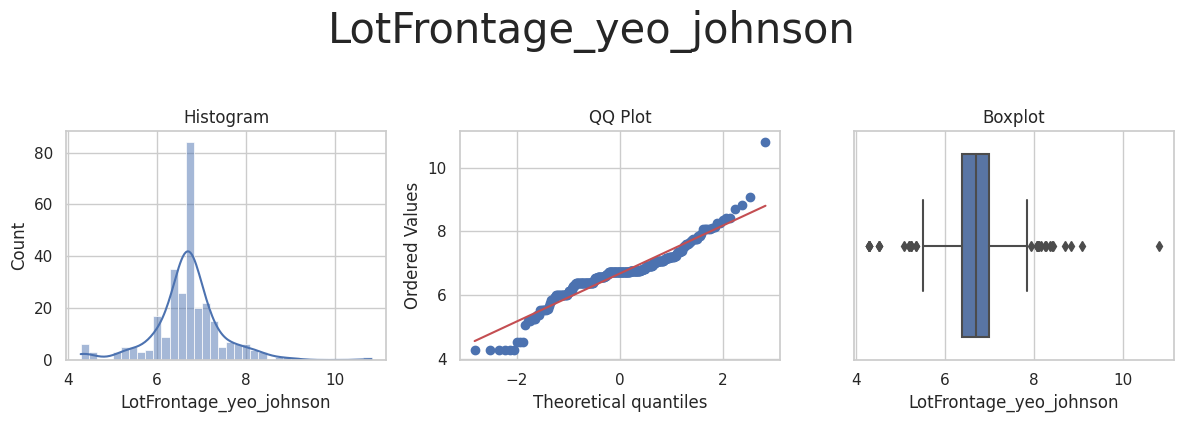



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



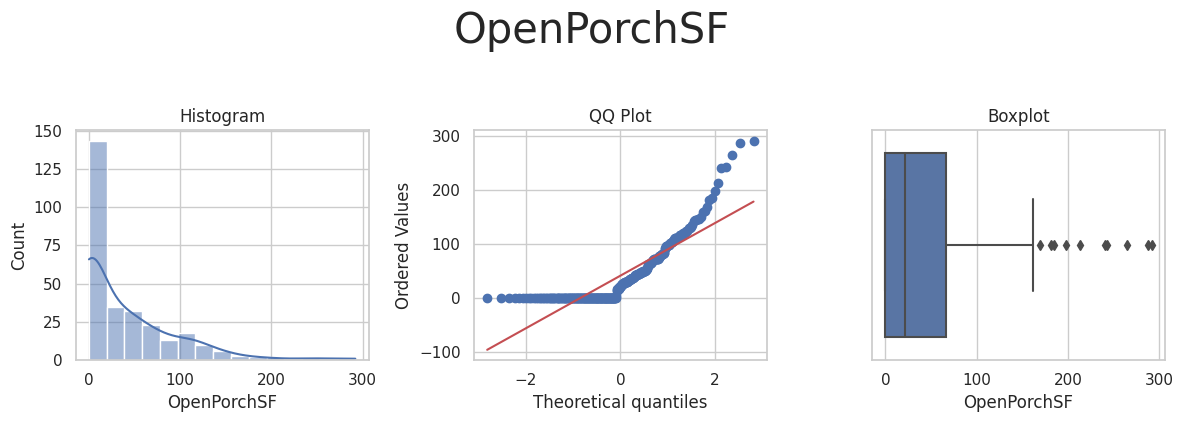

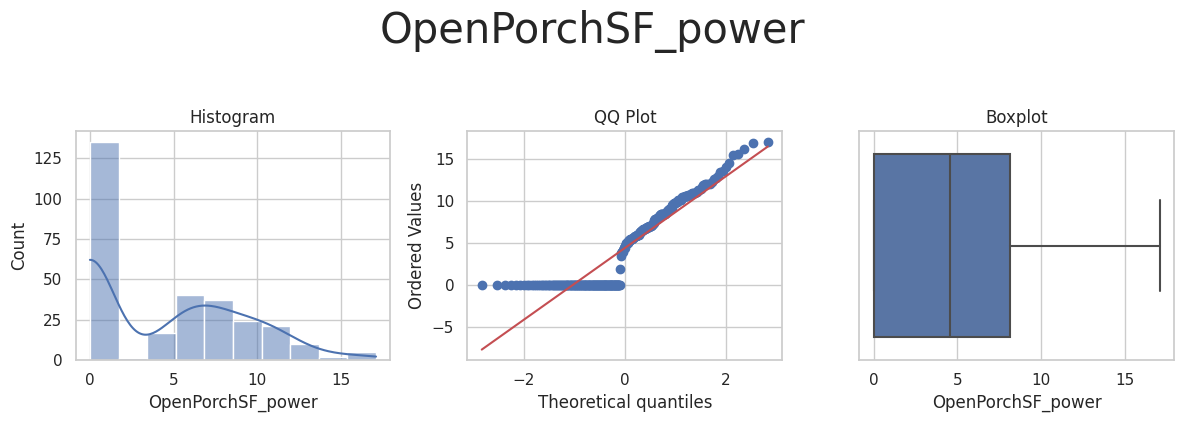

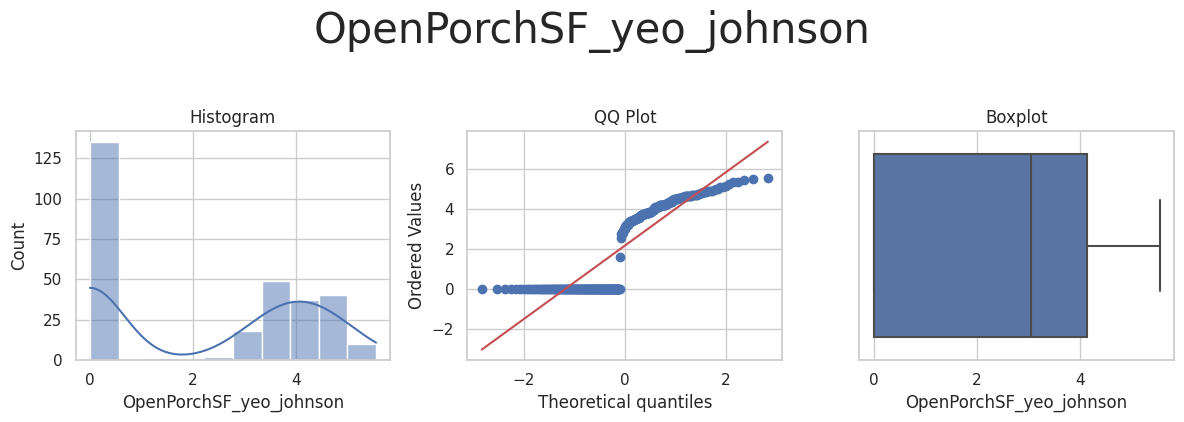



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



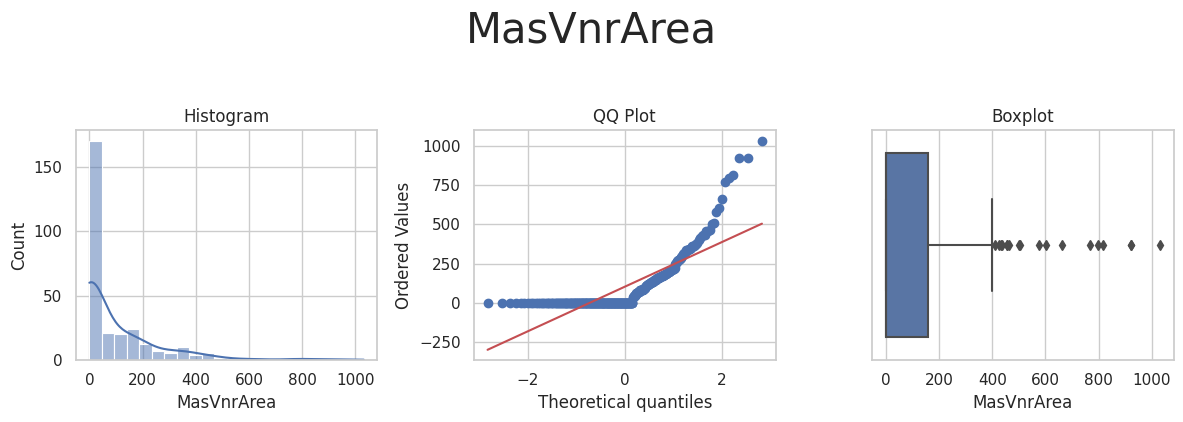

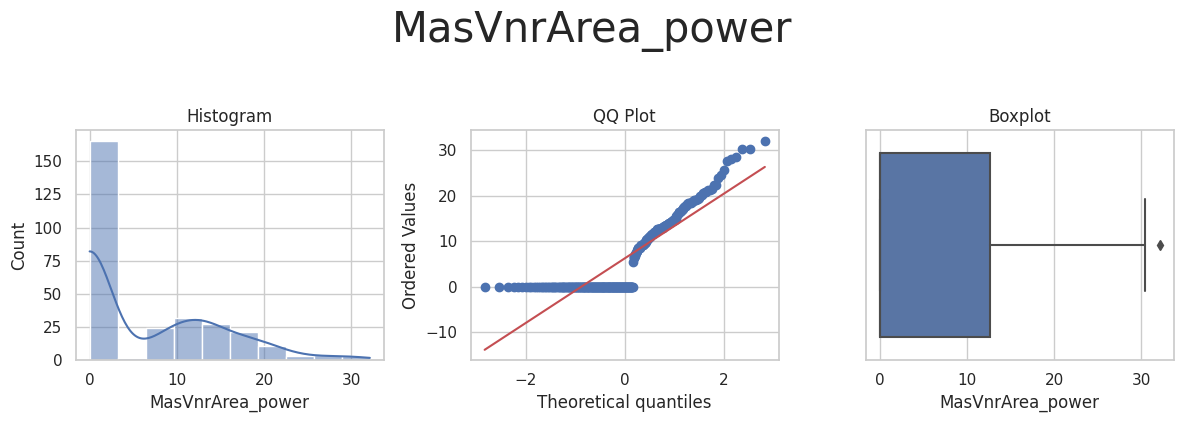

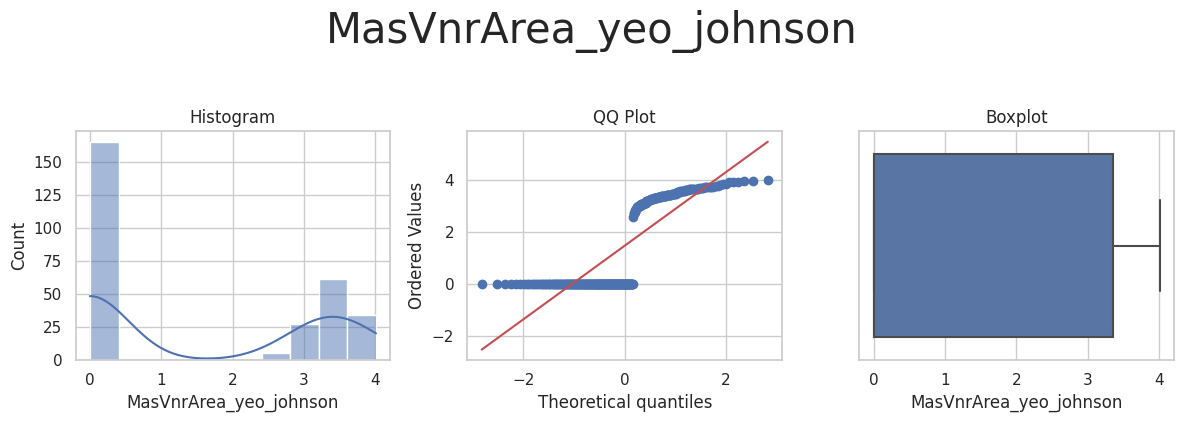

In [16]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

We determine to apply the following numerical transformations: 1stFlrSF - log_e, 2ndFlrSF - None, GrLivArea - log_e, BsmtFinSF1 - None, BsmtUnfinSF - yeo_johnson, TotalBsmtSF - yeo_johnson, GarageArea - yeo_johnson, LotArea - power, OpenPorchSF - None, LotFrontage - None, MasVnrArea - None.

Next assess the numerical transformations for the remaining numerical variables, repeating the same steps as before.

In [17]:
variables_engineering= ['BedroomAbvGr','GarageYrBlt','YearBuilt','YearRemodAdd']
variables_engineering

['BedroomAbvGr', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']

In [18]:
df_engineering = TestSet[variables_engineering].copy()
df_engineering.head(3)

BedroomAbvGr  GarageYrBlt  YearBuilt  YearRemodAdd
0           4.0       1975.0       1957          1975
1           3.0       1941.0       1941          1950
2           3.0       1950.0       1950          1950

* Variable Analyzed: BedroomAbvGr
* Applied transformation: ['BedroomAbvGr_power', 'BedroomAbvGr_yeo_johnson'] 



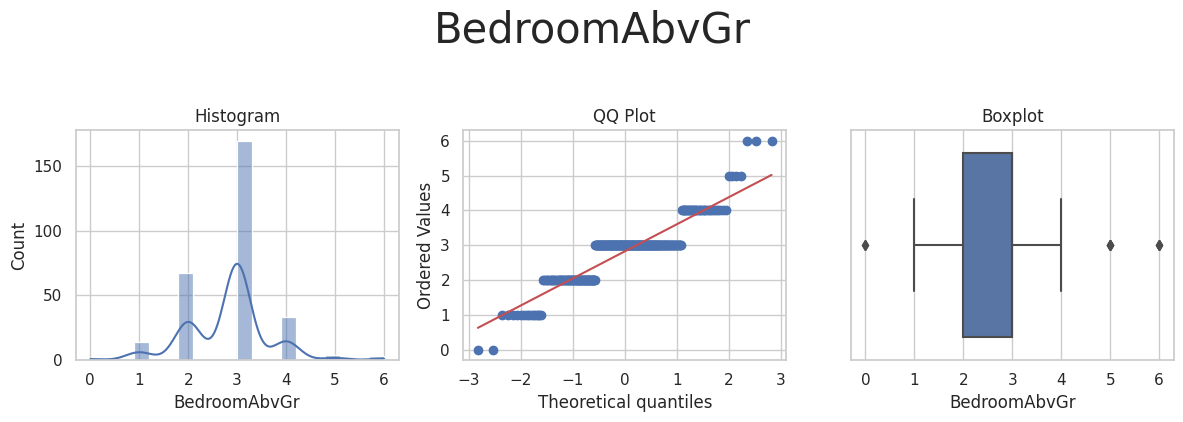

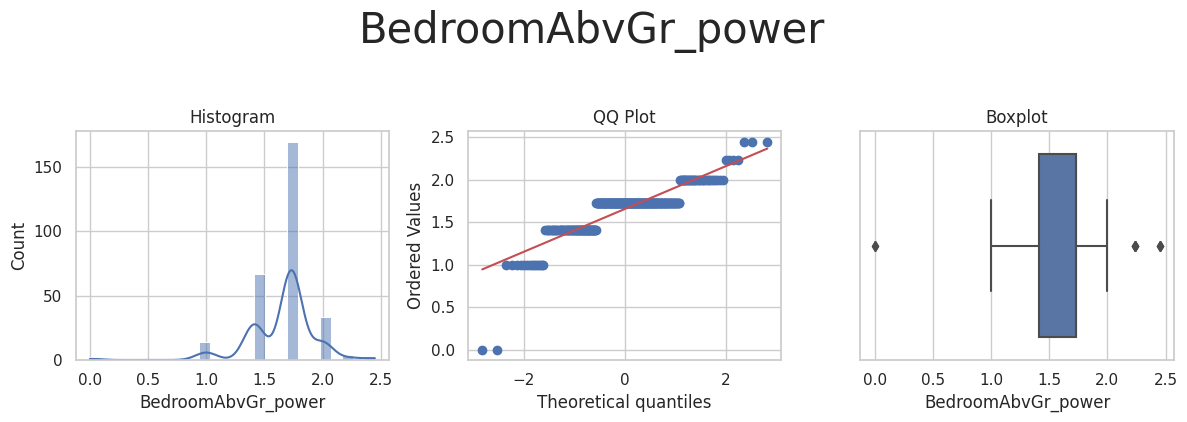

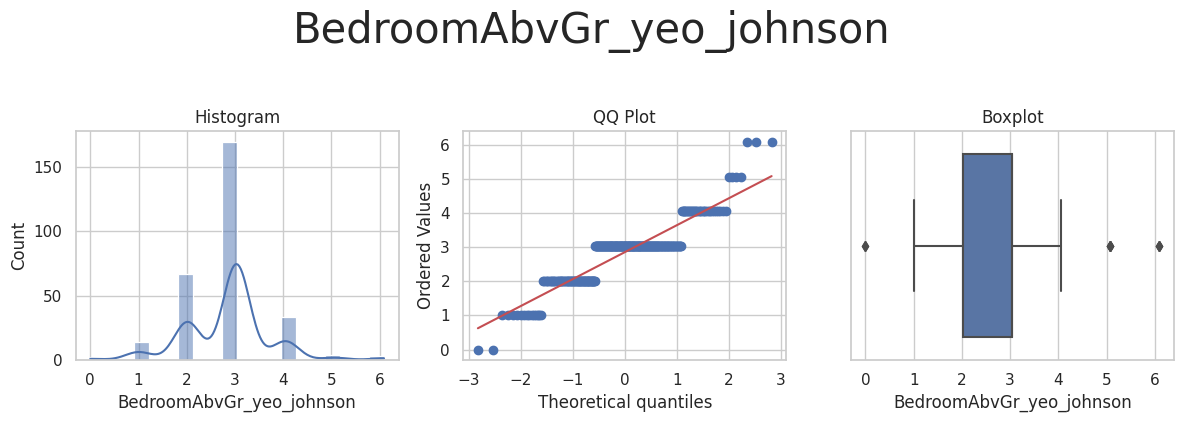



* Variable Analyzed: GarageYrBlt
* Applied transformation: ['GarageYrBlt_log_e', 'GarageYrBlt_log_10', 'GarageYrBlt_reciprocal', 'GarageYrBlt_power', 'GarageYrBlt_box_cox', 'GarageYrBlt_yeo_johnson'] 



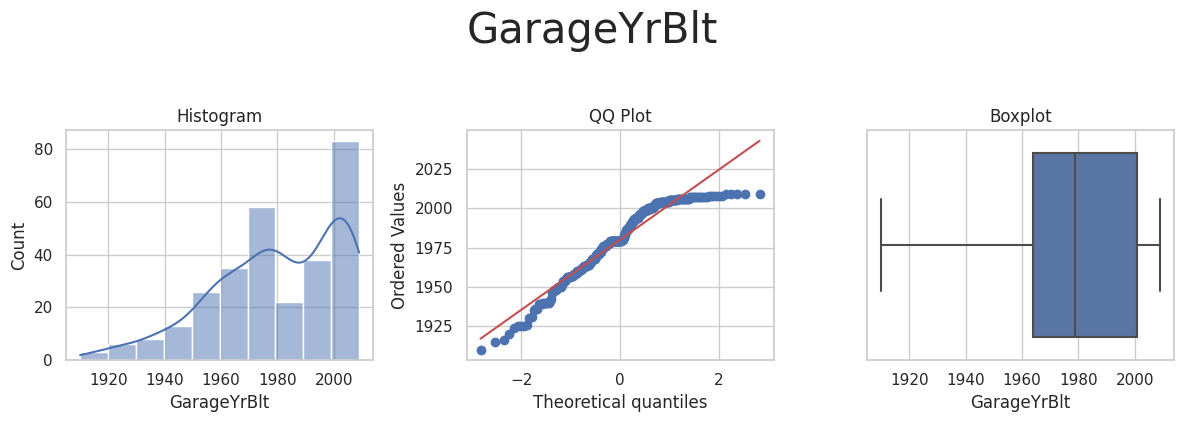

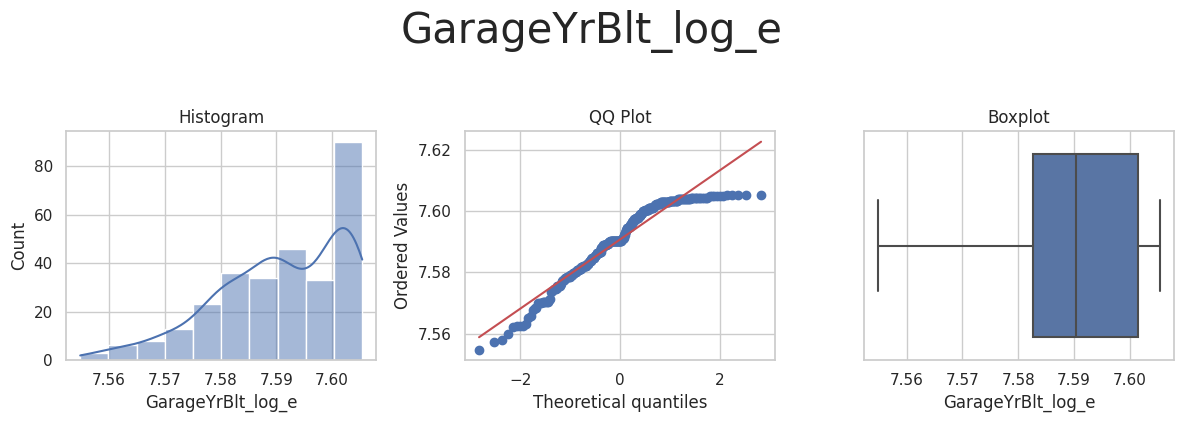

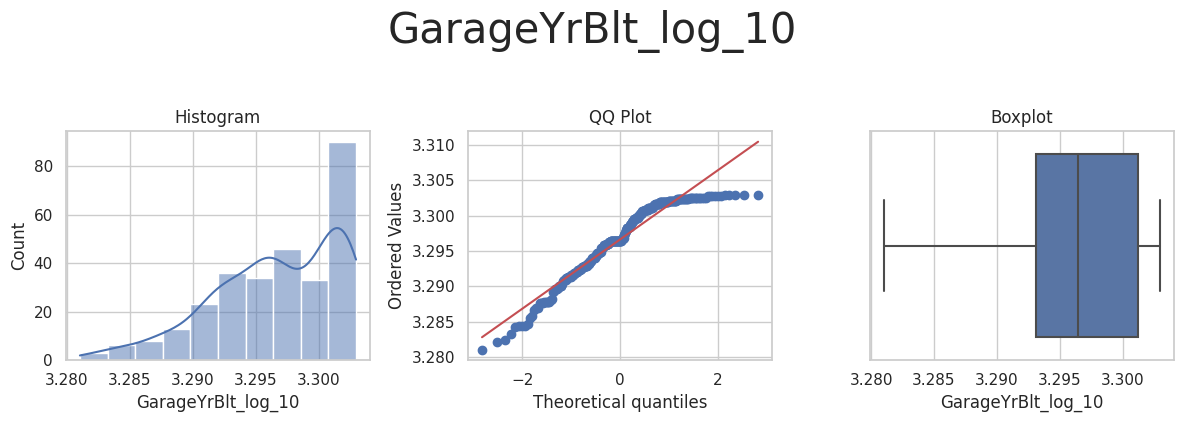

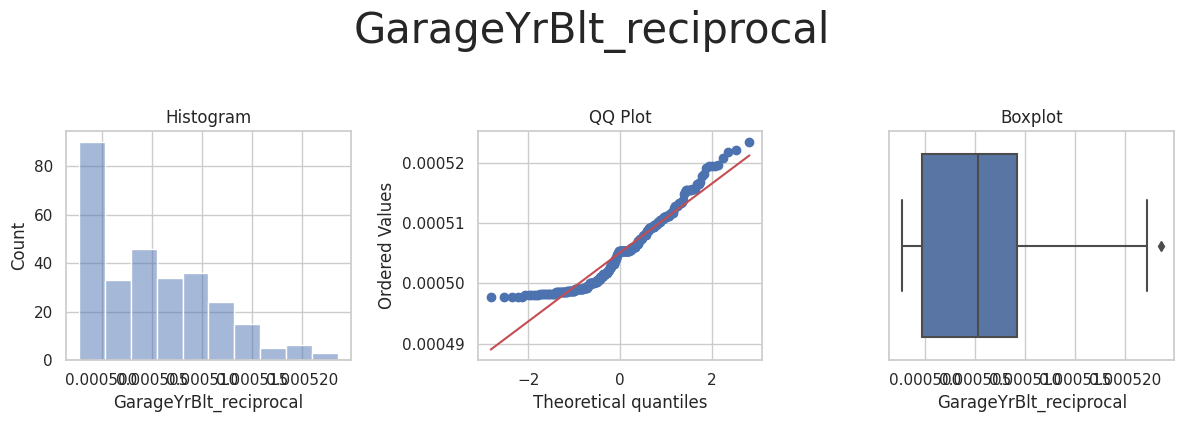

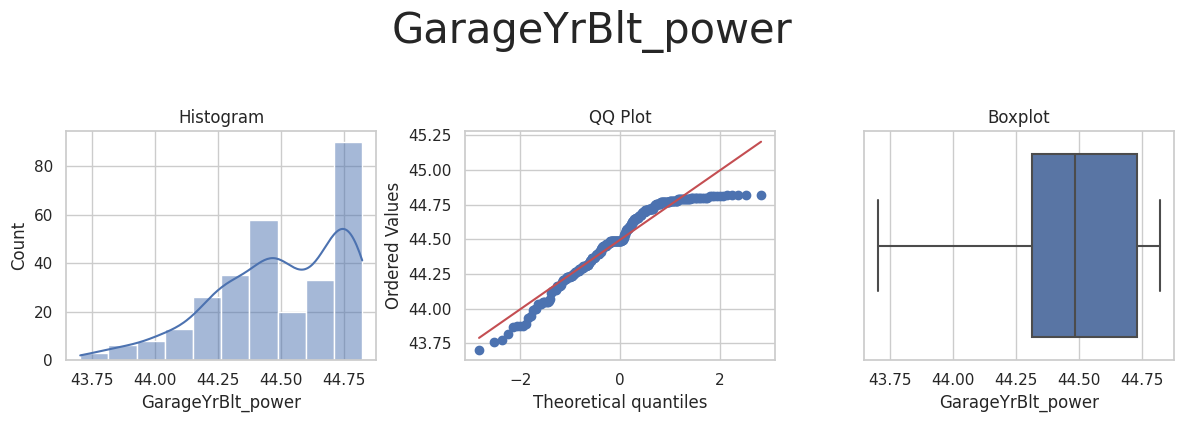

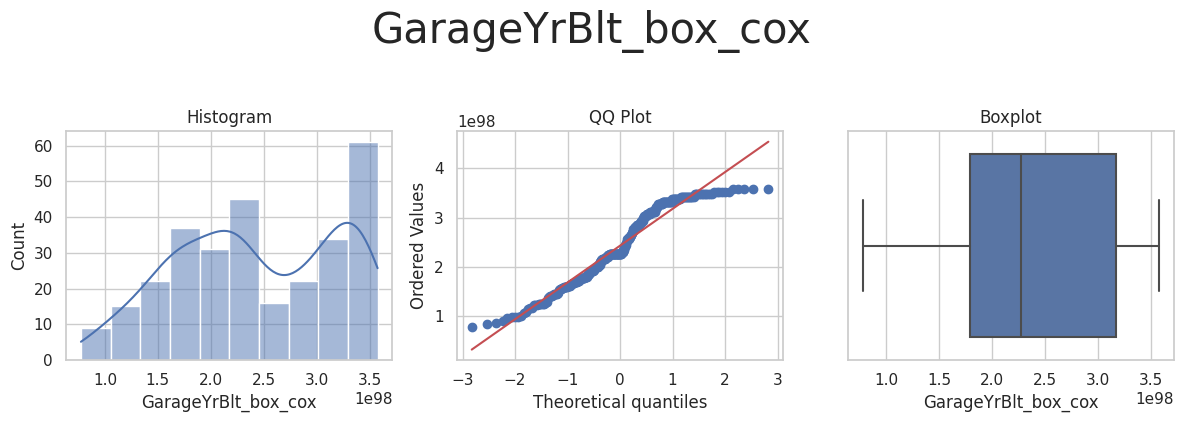

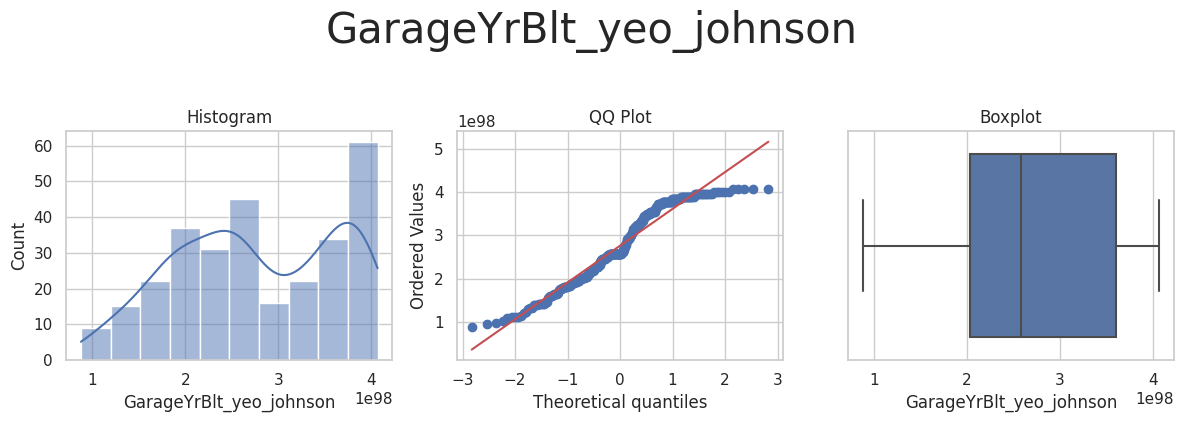



* Variable Analyzed: YearBuilt
* Applied transformation: ['YearBuilt_log_e', 'YearBuilt_log_10', 'YearBuilt_reciprocal', 'YearBuilt_power', 'YearBuilt_box_cox', 'YearBuilt_yeo_johnson'] 



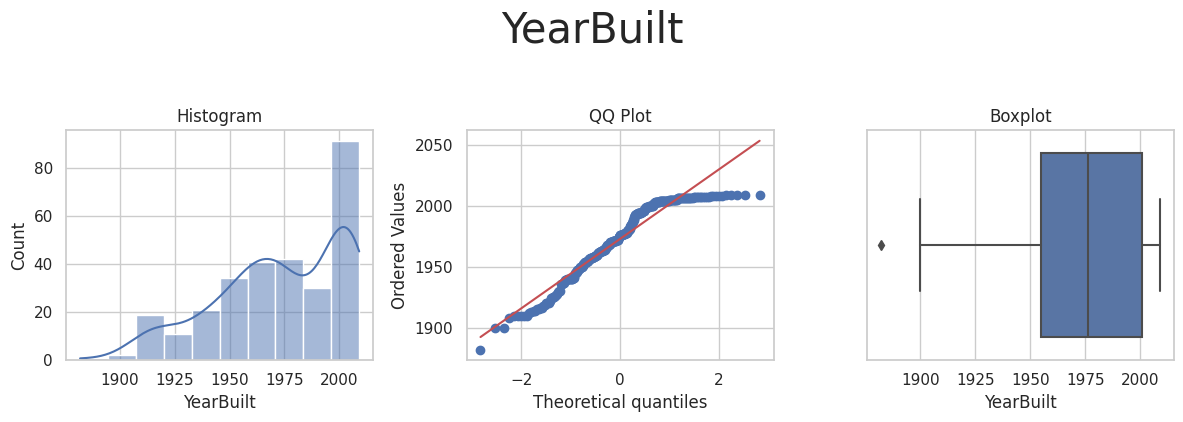

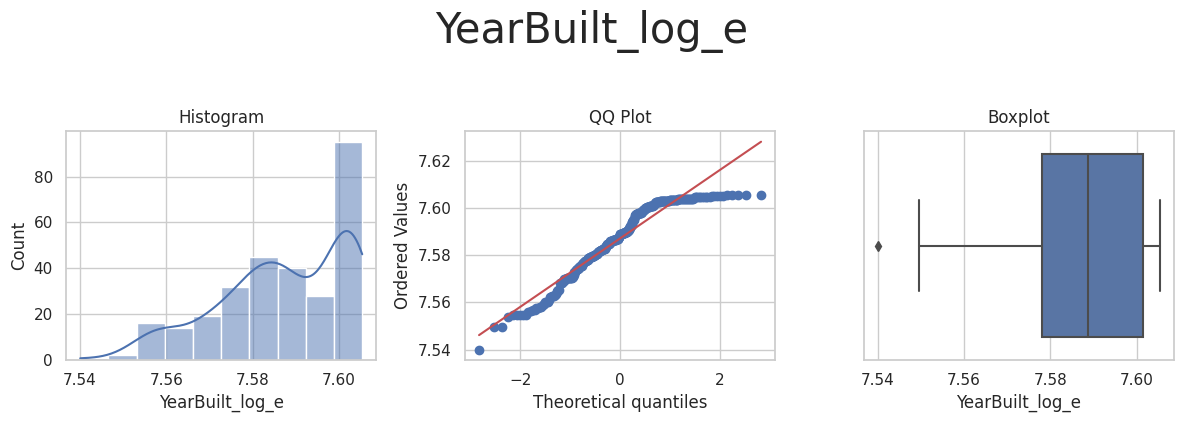

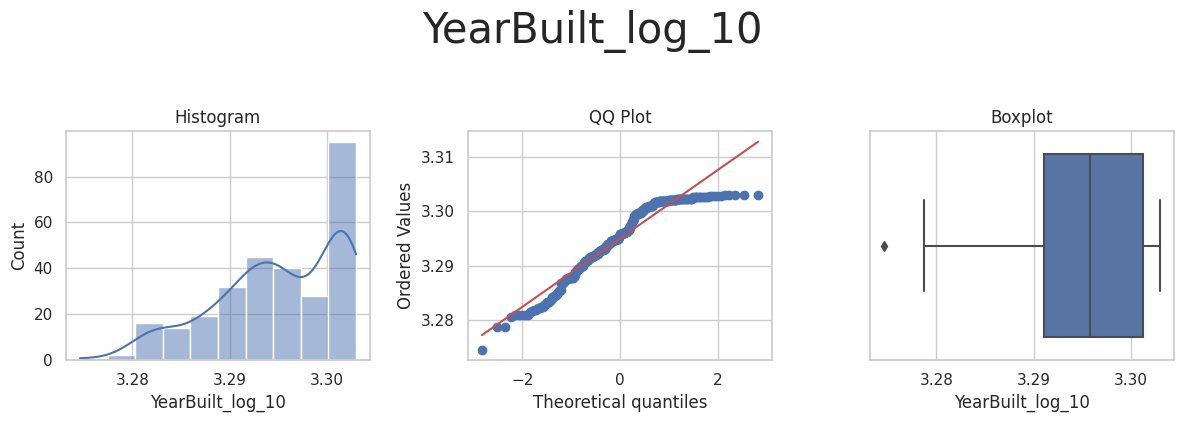

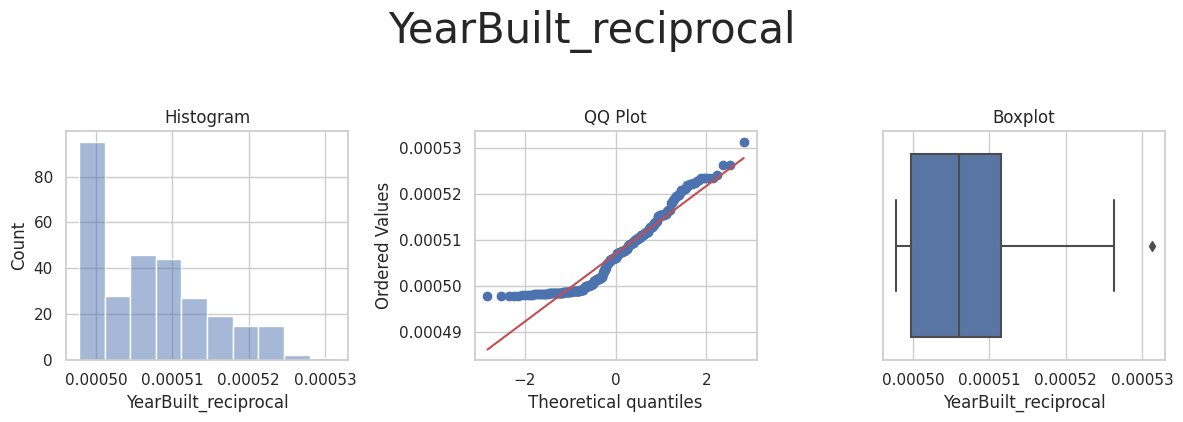

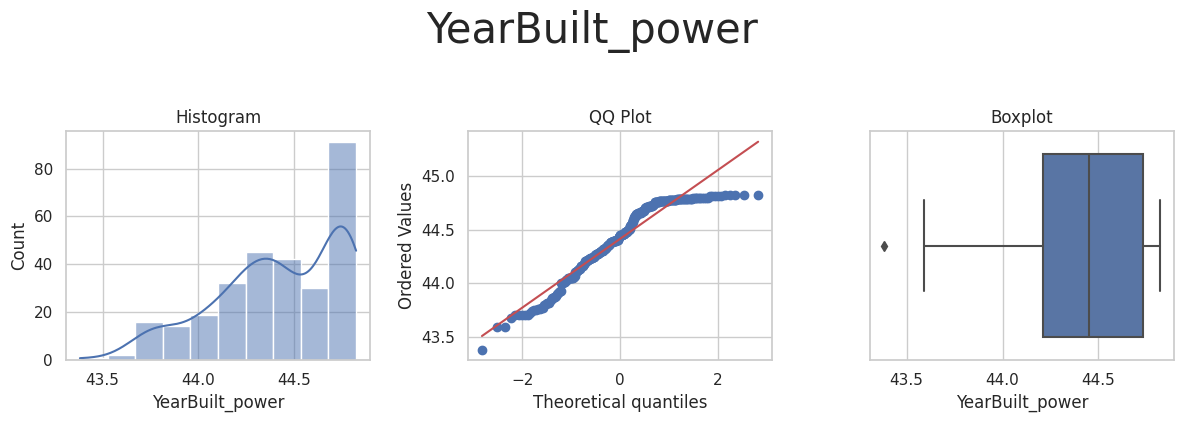

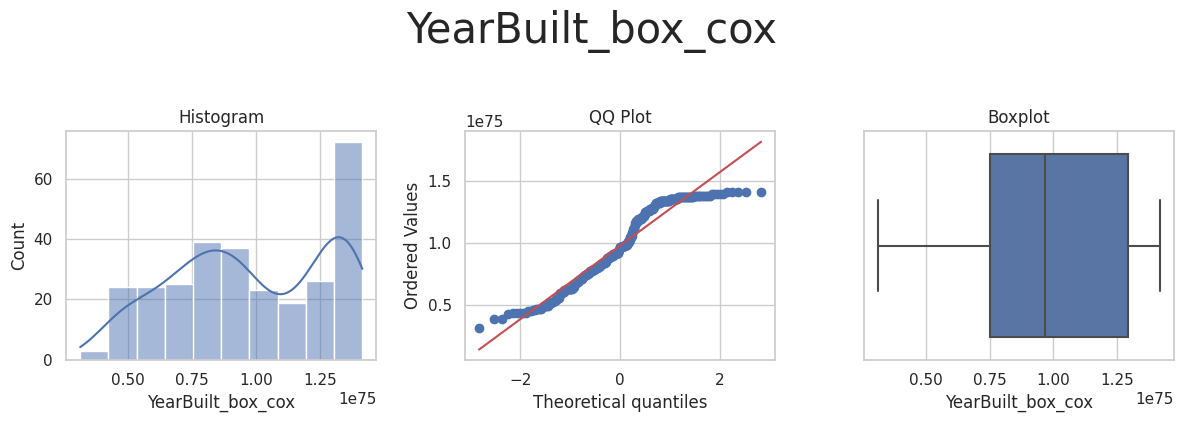

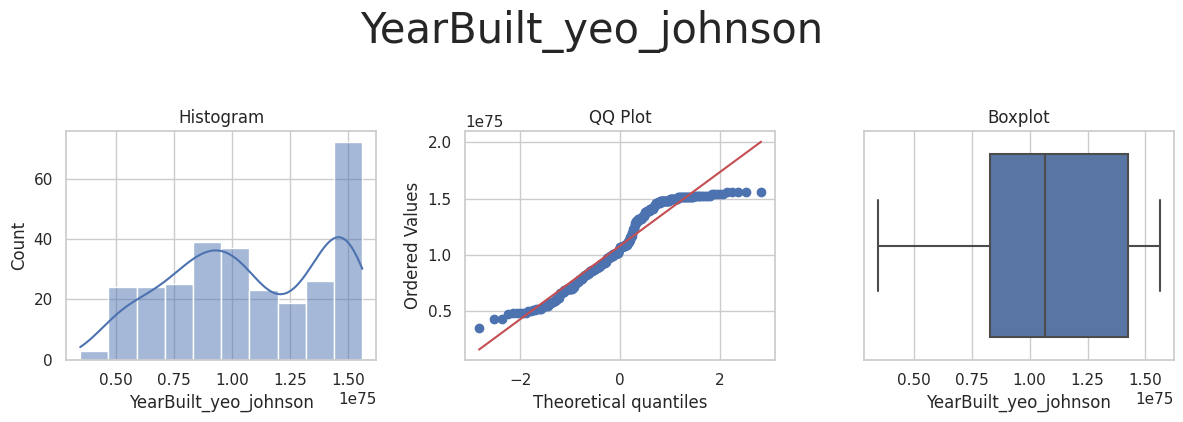



* Variable Analyzed: YearRemodAdd
* Applied transformation: ['YearRemodAdd_log_e', 'YearRemodAdd_log_10', 'YearRemodAdd_reciprocal', 'YearRemodAdd_power', 'YearRemodAdd_box_cox', 'YearRemodAdd_yeo_johnson'] 



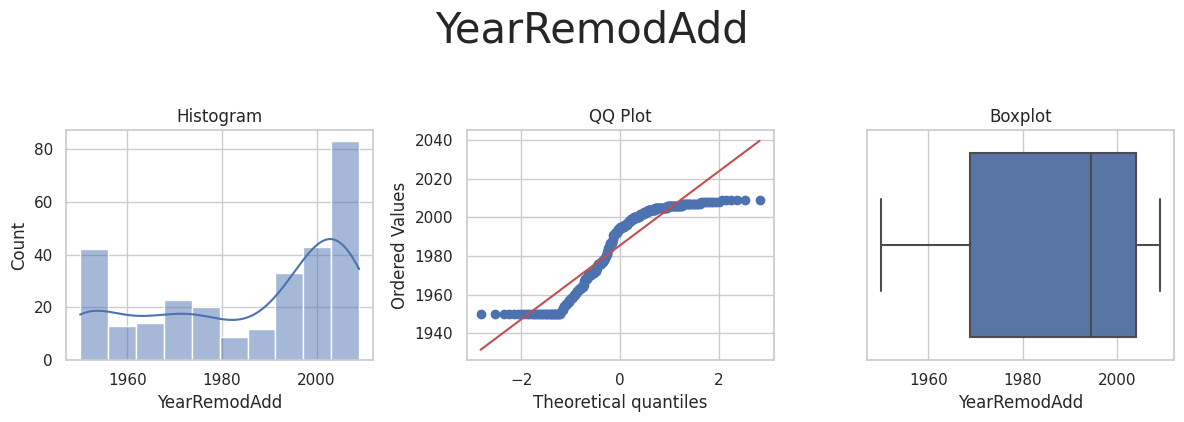

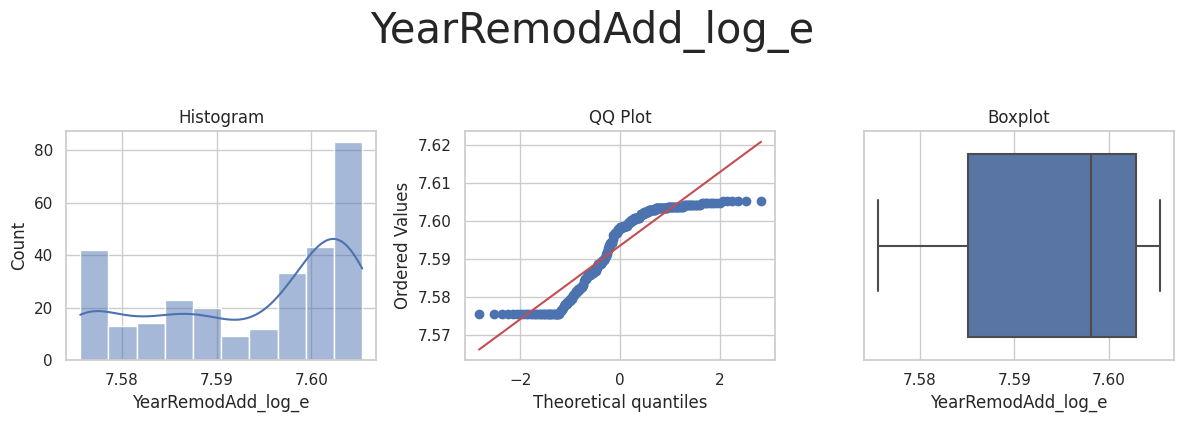

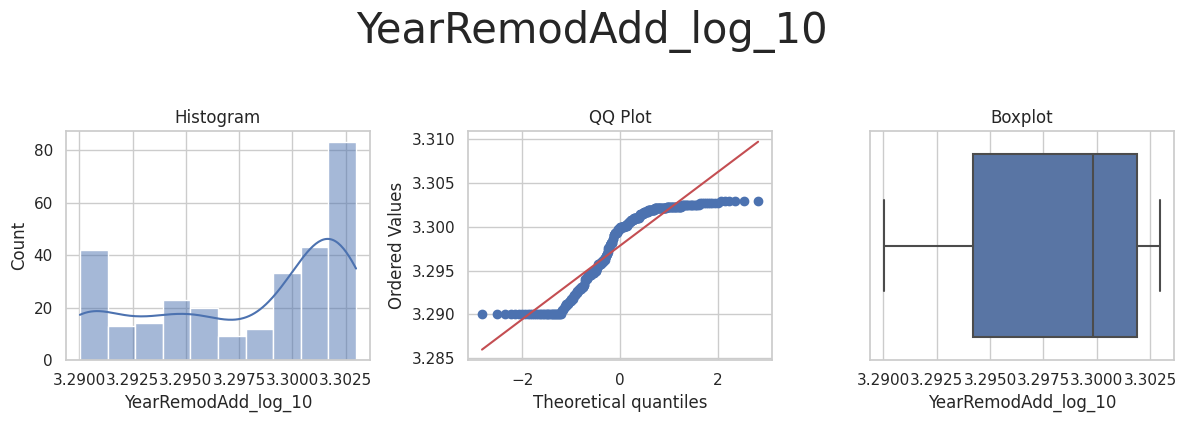

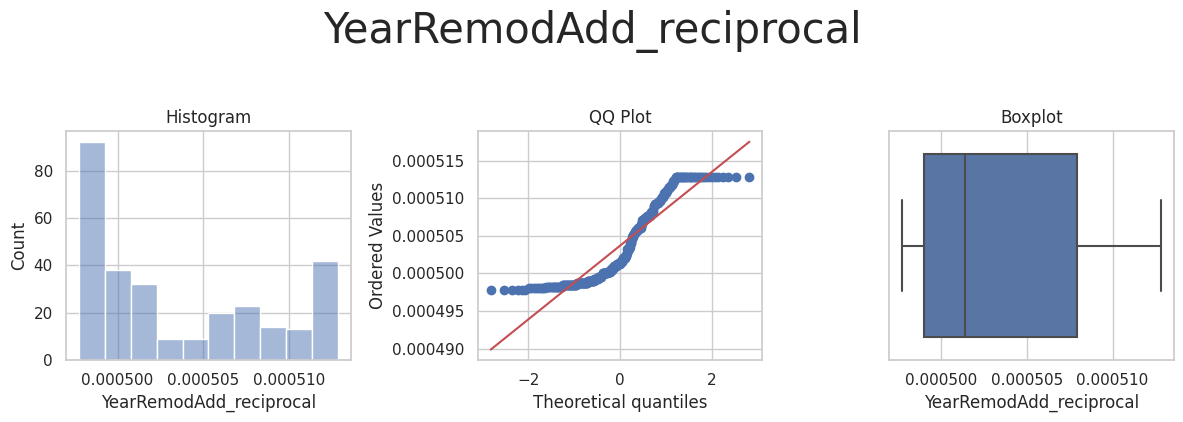

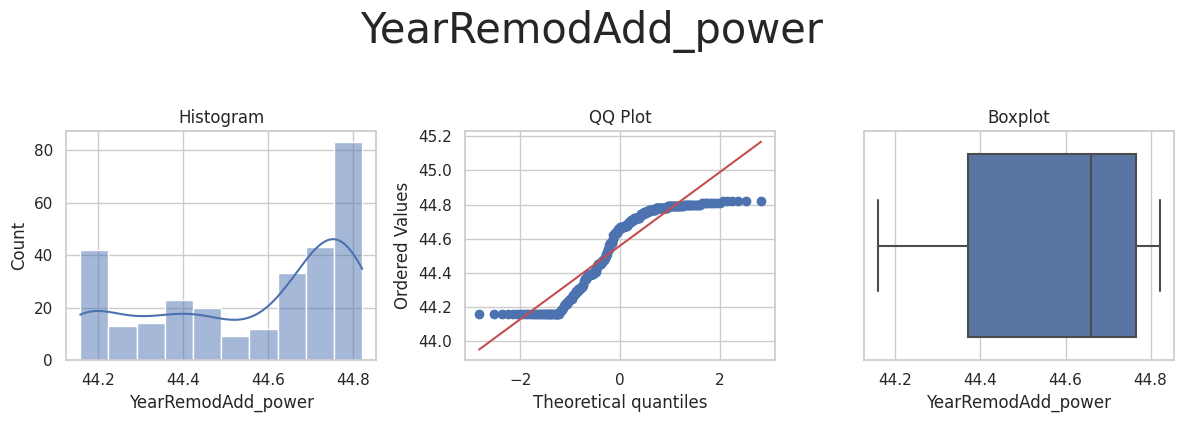

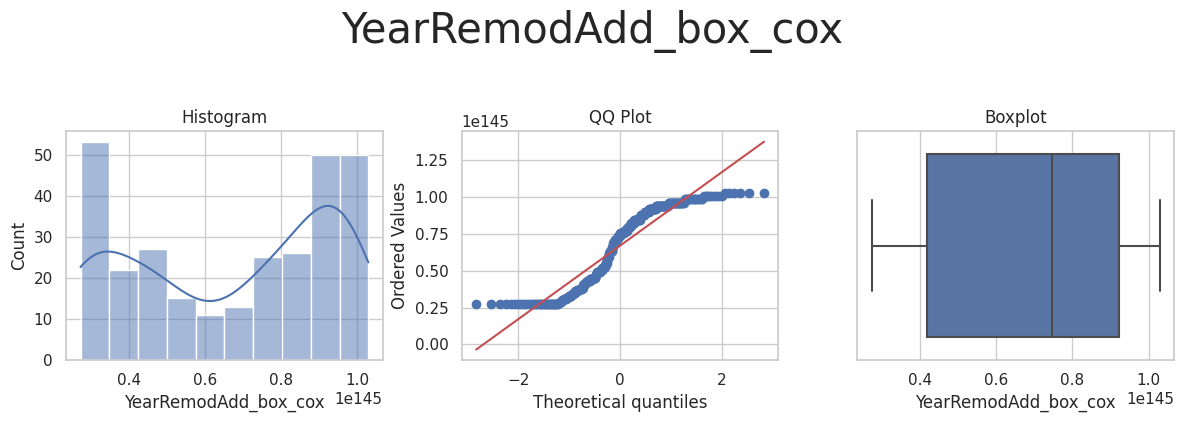

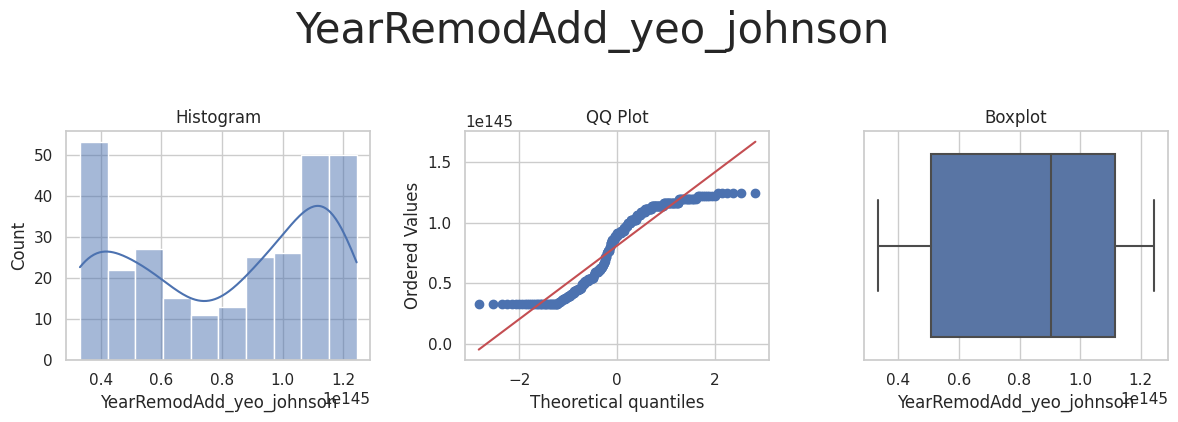

In [19]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

We determine not to apply any numerical transformations to the remaining four numerical variables.

So the final numerical features engieering pipeline is summarized in the the code cell below and applied to the train and test tests.

In [20]:
from sklearn.pipeline import Pipeline

variables_engineering_log= ['1stFlrSF','GrLivArea']
variables_engineering_yeo_johnson= ['BsmtUnfSF','GarageArea','TotalBsmtSF']
variables_engineering_power= ['LotArea']

# the steps are:
# 1. create the transformer
# 2. fit_transform the TrainSet
# 3. transform the TestSet

pipeline = Pipeline([
    ('log_transformer', vt.LogTransformer(variables=variables_engineering_log,base='e')),
    ('power_transformer', vt.PowerTransformer(variables=variables_engineering_power)),
    ('yeo_johnson_transformer', vt.YeoJohnsonTransformer(variables=variables_engineering_yeo_johnson))
])

TrainSet = pipeline.fit_transform(TrainSet)
TestSet = pipeline.transform(TestSet)

print("* Numerical transformations done!")

* Numerical transformations done!


## Assessing outliers

In [21]:
df_engineering = TrainSet.copy()
df_engineering.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0  7.510978       0.0           3.0           Av          48          Unf   
1  6.795706       0.0           2.0           No           0          Unf   
2  6.871091       0.0           2.0           No         713          ALQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...     LotArea  \
0  72.117860  285.045723          Unf       2007.0  ...  108.138800   
1  51.451694  133.391173          Unf       1962.0  ...   81.240384   
2  21.751877  176.329005          Unf       1921.0  ...  115.585466   

  LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  \
0        90.0       452.0          108            5            9   495.850351   
1        60.0         0.0            0            5            5   280.785318   
2        80.0         0.0            0            7            5   276.257124   

   YearBuilt  YearRemodAdd  SalePrice  
0       2007          2007     314813  
1       1962          1962     109500  
2       1921          2006     163500  

[3 rows x 22 columns]

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_iqr'] 



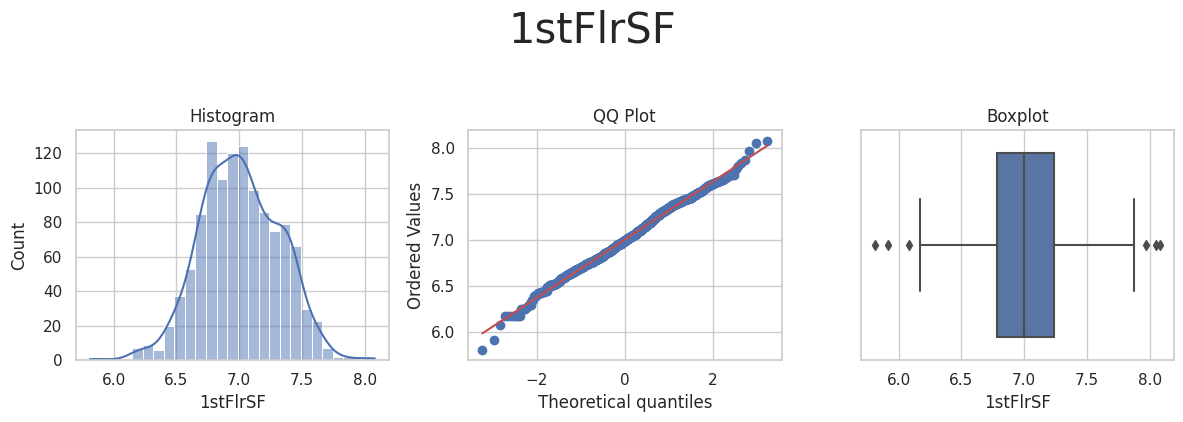

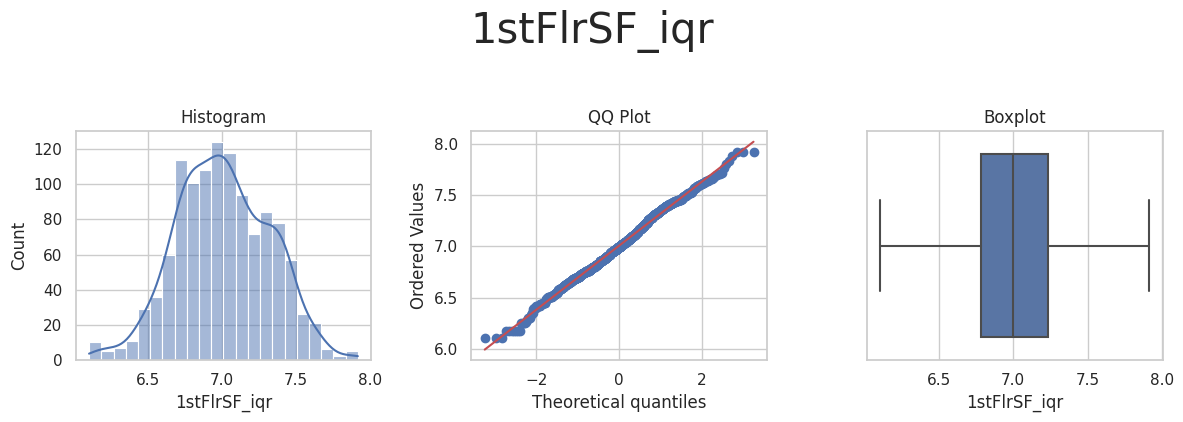



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_iqr'] 



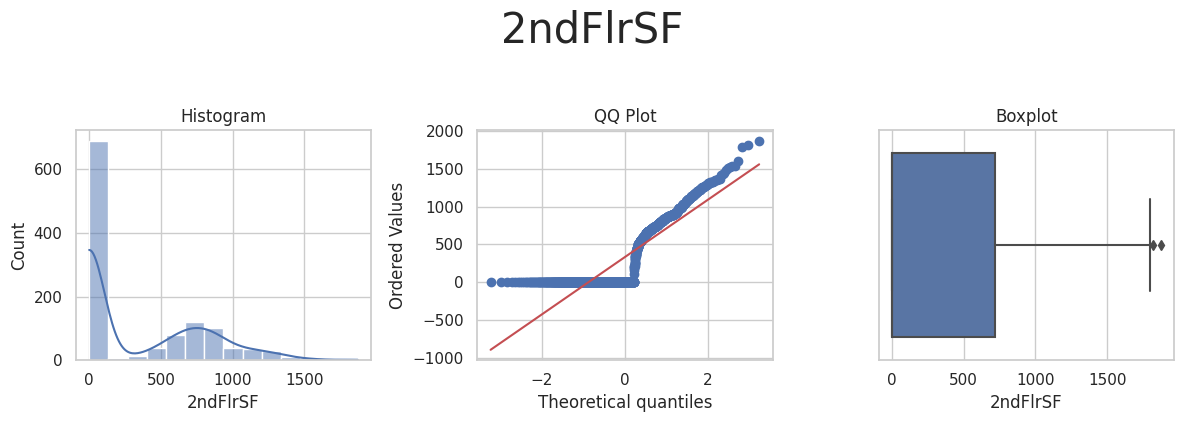

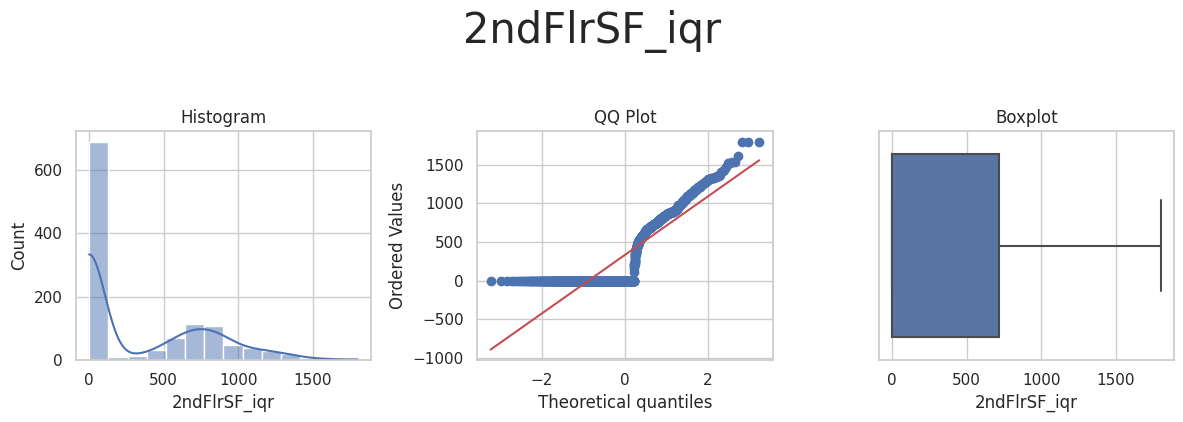



* Variable Analyzed: BedroomAbvGr
* Applied transformation: ['BedroomAbvGr_iqr'] 



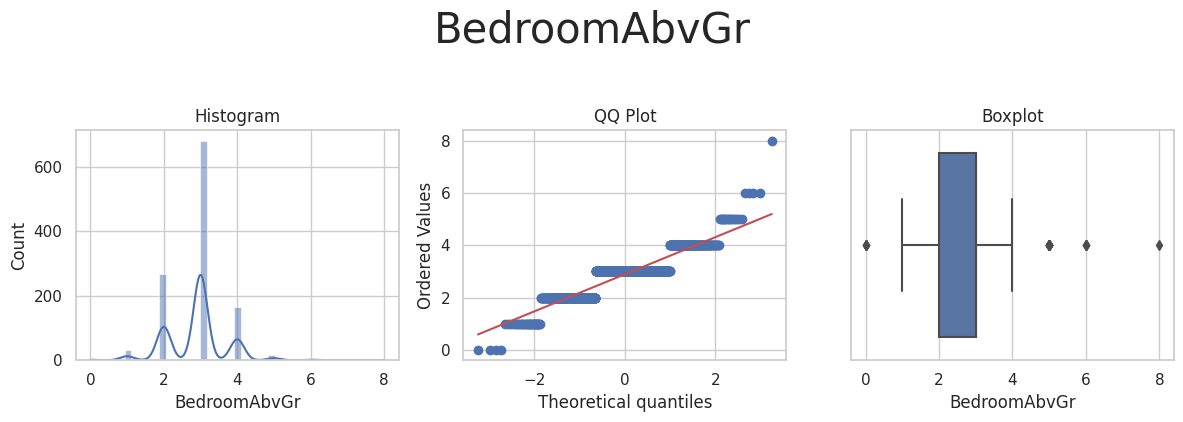

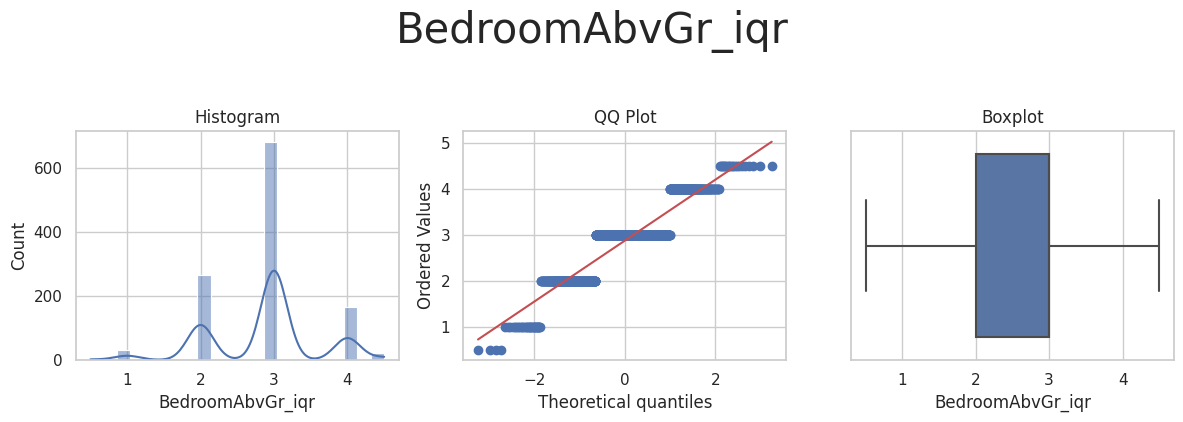



* Variable Analyzed: BsmtExposure
* Applied transformation: [] 



TypeError: unsupported operand type(s) for /: 'str' and 'int'

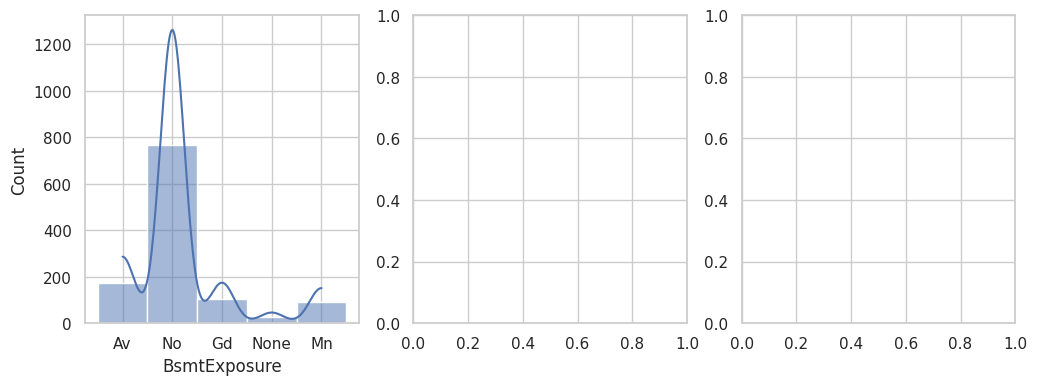

In [22]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='outlier_winsorizer')

df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='outlier_winsorizer')

In [23]:
from sklearn.pipeline import Pipeline

variables_engineering= ['GrLivArea']

# the steps are:
# 1. create the transformer
# 2. fit_transform the TrainSet
# 3. transform the TestSet

pipeline = Pipeline([
    ('windsorizer', Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=variables_engineering)),
])

TrainSet = pipeline.fit_transform(TrainSet)
TestSet = pipeline.transform(TestSet)

print("* Outlier transformations done!")

* Outlier transformations done!


## Smart Correlated Selection Variables

For this transformer there is no need to select variables, all the variables will be fed into the transformer. The transformer finds groups of correlated features and from each group of features it will select the most relevant one based on a variety of criteria, it will then drop the other non-critical features. The target variable 'SalePrice' Should not be included in this analysis, since it should not be dropped.

In [24]:
df_engineering = TrainSet.copy().drop(['SalePrice'],axis=1)
df_engineering.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0  7.510978       0.0           3.0           Av          48          Unf   
1  6.795706       0.0           2.0           No           0          Unf   
2  6.871091       0.0           2.0           No         713          ALQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  KitchenQual  \
0  72.117860  285.045723          Unf       2007.0  ...           Gd   
1  51.451694  133.391173          Unf       1962.0  ...           TA   
2  21.751877  176.329005          Unf       1921.0  ...           TA   

      LotArea  LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0  108.138800         90.0       452.0          108            5            9   
1   81.240384         60.0         0.0            0            5            5   
2  115.585466         80.0         0.0            0            7            5   

   TotalBsmtSF  YearBuilt  YearRemodAdd  
0   495.850351       2007          2007  
1   280.785318       1962          1962  
2   276.257124       1921          2006  

[3 rows x 21 columns]

In [28]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="pearson", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
print("* The following groups of correlated variables have been identified:")
corr_sel.correlated_feature_sets_

* The following groups of correlated variables have been identified:


[{'1stFlrSF', 'TotalBsmtSF'},
 {'2ndFlrSF', 'GrLivArea'},
 {'GarageYrBlt', 'YearBuilt', 'YearRemodAdd'}]

In [29]:
print("* The Smart Correlation Selection has determined to drop the following features:")
corr_sel.features_to_drop_

* The Smart Correlation Selection has determined to drop the following features:


['1stFlrSF', 'GarageYrBlt', 'GrLivArea', 'YearRemodAdd']

# Conclusion: Proposed transformations

* The table below lists the transformations that have been determined to be applicable given the features present in the data set.

* The Smart Corrleation Selection has determined that the following variable should be dropped: '1stFlrSF', 'GarageYrBlt', 'GrLivArea', and 'YearRemodAdd'.

* These transformation will be added to the ML Pipeline.



Variable	Proposed Transformation
BsmtExposure	OrdinalEncoder, SmartCorrelatedSelection
BsmtFinType1	OrdinalEncoder, SmartCorrelatedSelection
GarageFinish	OrdinalEncoder, SmartCorrelatedSelection
KitchenQual	OrdinalEncoder, SmartCorrelatedSelection
OverallCond	SmartCorrelatedSelection
OverallQual	SmartCorrelatedSelection
1stFlrSF	Numerical - log_e, SmartCorrelatedSelection
2ndFlrSF	SmartCorrelatedSelection
BsmtFinSF1	SmartCorrelatedSelection
BsmtUnfSF	Numerical - yeo_johnson, SmartCorrelatedSelection
GarageArea	Numerical - yeo_johnson, SmartCorrelatedSelection
GrLivArea	Numerical - log_e, Windsorizer, SmartCorrelatedSelection
LotArea	Numerical - power, SmartCorrelatedSelection
LotFrontage	SmartCorrelatedSelection
MasVnrArea	SmartCorrelatedSelection
OpenPorchSF	SmartCorrelatedSelection
TotalBsmtSF	Numerical - yeo_johnson, SmartCorrelatedSelection
BedroomAbvGr	SmartCorrelatedSelection
GarageYrBlt	SmartCorrelatedSelection
YearBuilt	SmartCorrelatedSelection
YearRemodAdd	SmartCorrelatedSelection
SalePrice	None - target variable

## Conclusions and Next Steps

* In this notebook we have done an extensive feature analysis and feature engineering on the data set.
* We have determined a list of transformation to apply and which variables to apply them to.
* We have compiled individual pipelines for each type of transformation.
* In the next notebook we will compile them into a single pipeline and determine the best model for predicting the target value.
* No files need to be pushed to the repository based on this notebook.

In [25]:
!git add .

In [27]:
!git  commit -m "Sales price analysis notebook"

[main 9221ff4] Sales price analysis notebook
 2 files changed, 45599 insertions(+)
 create mode 100644 jupyter_notebooks/.ipynb_checkpoints/Sales_prices_analysis_notebook-checkpoint.ipynb
 create mode 100644 jupyter_notebooks/Sales_prices_analysis_notebook.ipynb


In [ ]:
!git